# Dataset Preparation and Bias Analysis

This notebook corresponds to the sections _Dataset Description and Preparation_ and _Analysis of Protocol and Instrument Biases_ of the final report.

This notebook covers the first part of the project, focusing on:

- Cleaning and preprocessing the dataset: log-transformation, distribution analysis, and outlier detection using IQR, Isolation Forest, and Quantile Regression.
- Exploring protocol and instrument biases: statistical analysis of how measurement protocols (EUSAAR, NIOSH) and instrument types (MAAP, AE, LVol, HVol) affect the relationship between Black Carbon (BC) and Elemental Carbon (EC).
- Modeling and visualizing these effects using ANOVA, linear regression, and median quantile regression to quantify systematic discrepancies in EC/BC ratios.

In [12]:
import pandas as pd

# Load the dataset
df = pd.read_csv('dataset/EC_BC_20250329.csv')

# Drop unnecessary columns
cols_to_drop = ['Unnamed: 0', 'Latitude', 'Longitude', 'Altitude', 
                       'Station_Type', 'Station_Name']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Reorder the columns
desired_order = [
    'Station_name', 'ID', 'Datetime', 'Instrument', 'Protocol',
    'EC_BC', 'EC_BC_merged', 'BC', 'EC', 'Instrument_EC',
    'Instrument_BC', 'OC', 'MAC', 'Size_cut', 'C_value',
    'H_value', 'BC_sloped', 'Flag_MCH'
]
df = df[desired_order]

# Display the dataframe
display(df)

/var/folders/8s/fjskjb050nsf6qwhyq994z500000gn/T/ipykernel_35686/869086640.py:4: DtypeWarning: Columns (5,7,8,11,14,15,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/EC_BC_20250329.csv')


,Station_name,ID,Datetime,Instrument,Protocol,EC_BC,EC_BC_merged,BC,EC,Instrument_EC,Instrument_BC,OC,MAC,Size_cut,C_value,H_value,BC_sloped,Flag_MCH
0,Passy,ID156,2017-11-27 00:00:00+00:00,HVol_Filters,999.9,0,2.559560,NaN,2.55956,HVol_Filters,NaN,8.86,NaN,1.00,NaN,NaN,NaN,1.00
1,Passy,ID156,2017-11-29 00:00:00+00:00,HVol_Filters,999.9,0,1.151130,NaN,1.15113,HVol_Filters,NaN,5.75,NaN,1.00,NaN,NaN,NaN,1.00
2,Passy,ID156,2017-11-30 00:00:00+00:00,HVol_Filters,999.9,0,1.563940,NaN,1.56394,HVol_Filters,NaN,8.0,NaN,1.00,NaN,NaN,NaN,1.00
3,Passy,ID156,2017-12-02 00:00:00+00:00,HVol_Filters,999.9,0,1.647690,NaN,1.64769,HVol_Filters,NaN,8.33,NaN,1.00,NaN,NaN,NaN,1.00
4,Passy,ID156,2017-12-03 00:00:00+00:00,HVol_Filters,999.9,0,1.624490,NaN,1.62449,HVol_Filters,NaN,10.42,NaN,1.00,NaN,NaN,NaN,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316946,Zürich-Kaserne,ID824,2021-12-28 00:00:00+00:00,AE33,NaN,1,0.205075,0.205075,NaN,NaN,AE33,NaN,1.39,1.76,1.39,1.76,0.139507,1.76
316947,Zürich-Kaserne,ID824,2021-12-29 00:00:00+00:00,AE33,NaN,1,0.157050,0.15705,NaN,NaN,AE33,NaN,1.39,1.76,1.39,1.76,0.106837,1.76
316948,Zürich-Kaserne,ID824,2021-12-30 00:00:00+00:00,AE33,NaN,1,0.417923,0.417923,NaN,NaN,AE33,NaN,1.39,1.76,1.39,1.76,0.284302,1.76
316949,Zürich-Kaserne,ID824,2021-12-31 00:00:00+00:00,AE33,NaN,1,0.758795,0.758795,NaN,NaN,AE33,NaN,1.39,1.76,1.39,1.76,0.516187,1.76


First, a small correction of the dataframe is necessary.

In [15]:
import numpy as np

# Function to update each row based on the EC_BC value
def update_instruments(row):
    if row['EC_BC'] == 0:
        row['Instrument_EC'] = row['Instrument']
        row['Instrument_BC'] = np.nan
    elif row['EC_BC'] == 1:
        row['Instrument_BC'] = row['Instrument']
        row['Instrument_EC'] = np.nan
    return row

# Apply the function row-wise to the DataFrame
df = df.apply(update_instruments, axis=1)

# Replace '999.9' (string) and NaN with 'UNKNOWN'
df['Protocol'] = df['Protocol'].replace(['999.9', np.nan], 'UNKNOWN')

# Replace 'EUSAAR1' and 'EUSAAR2' with 'EUSAAR'
df['Protocol'] = df['Protocol'].replace({'EUSAAR1': 'EUSAAR', 'EUSAAR2': 'EUSAAR'})

# Replace 'Filters' and NaN with 'UNKNOWN' in the 'Instrument_EC' column
df['Instrument_EC'] = df['Instrument_EC'].replace(['Filters', 'unknown', np.nan], 'UNKNOWN')

# Replace all AE variants with 'AE'
df['Instrument_BC'] = df['Instrument_BC'].replace(to_replace=r'^AE\d*$', value='AE', regex=True)

# Replace the specific BC instruments values with 'UNKNOWN'
df['Instrument_BC'] = df['Instrument_BC'].replace(['LVol_Filters', 'Filters', 'unknown', np.nan], 'UNKNOWN')

# Specific replacement for PSAP-ITM and MWAA
df['Instrument_BC'] = df['Instrument_BC'].replace(['PSAP-ITM', 'MWAA'], 'MAAP')

# Size_cut: replace 0.0, 999.9 and NaN with 999.0
df['Size_cut'] = df['Size_cut'].replace([0.0, 999.9, np.nan], 999.0)

# OC: replace Filters and NaN with 999.0
df['OC'] = df['OC'].replace(['Filters', np.nan], 999.0).round(1)

# MAC: replace 999, 999.0, 999.00 and NaN with 999.0
df['MAC'] = df['MAC'].replace([999, 999.0, 999.00, np.nan], 999.0).round(1)

# C_value: replace 999, 999.0, 999.00 and NaN with 999.0
df['C_value'] = df['C_value'].replace([999, 999.0, 999.00, np.nan], 999.0).round(1)

# H_value: replace only NaN with 999.0
df['H_value'] = df['H_value'].fillna(999.0).round(1)

# Flag_MCH: replace only NaN with 1 (inferred value)
df['Flag_MCH'] = df['Flag_MCH'].fillna(1)

# Replace by the right date format 
df['Datetime'] = df['Datetime'].apply(lambda x: x + ' 00:00:00' if len(x) == 10 else x)

# Convertir la colonne en format datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

Let's save these changes.

In [ ]:
# Save the DataFrame to CSV
df.to_csv('dataset/dataframe.csv', index=False)

Each row represents a measurement taken at an air quality monitoring station. The dataset focuses environmental and measurement parameters, but mainly Black Carbon and Elemental Carbon, two key pollutants emitted from combustion sources. Other informations about measurement method and data quality are provided.

Before initiating more in-depth analyses, it is crucial to understand the structure and content of the dataset. For that, we will explore the distribution of Black Carbon (BC) and Elemental Carbon (EC) concentrations. This can help us understand the variability of the measurements and detect potential outliers.

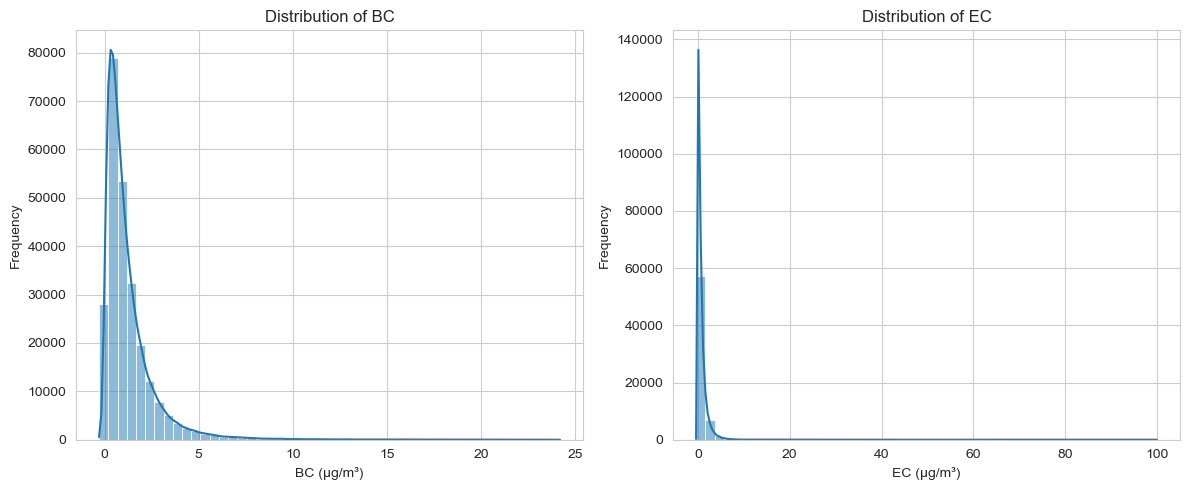

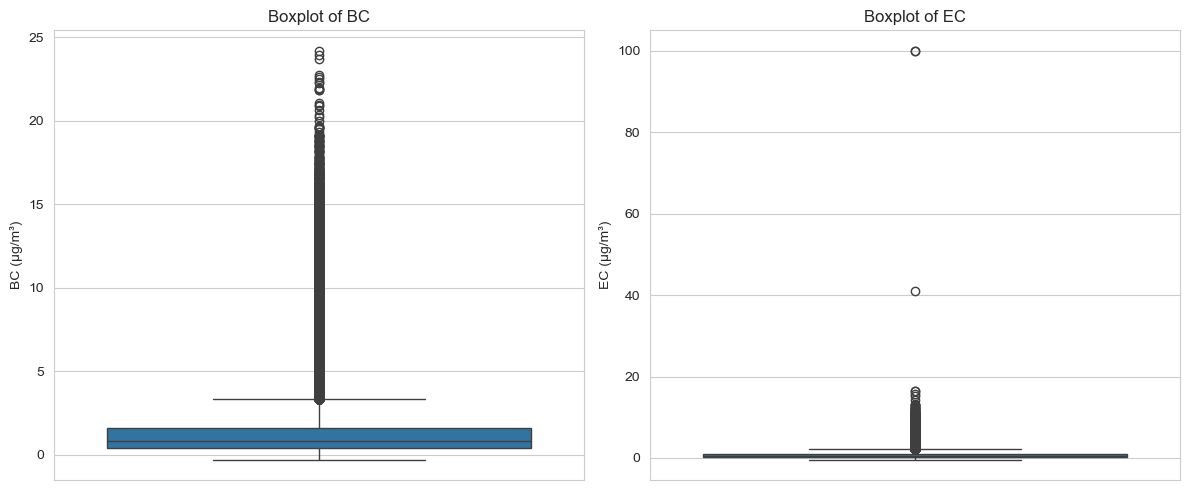

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Applied style
sns.set_style("whitegrid")

# Convert to numeric
df["BC"] = pd.to_numeric(df["BC"], errors='coerce')
df["EC"] = pd.to_numeric(df["EC"], errors='coerce')

# Histograms for BC and EC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df["BC"].dropna(), bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of BC")
axes[0].set_xlabel("BC (µg/m³)")
axes[0].set_ylabel("Frequency")

sns.histplot(df["EC"].dropna(), bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of EC")
axes[1].set_xlabel("EC (µg/m³)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Boxplots for BC and EC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df["BC"].dropna(), ax=axes[0])
axes[0].set_title("Boxplot of BC")
axes[0].set_ylabel("BC (µg/m³)")

sns.boxplot(y=df["EC"].dropna(), ax=axes[1])
axes[1].set_title("Boxplot of EC")
axes[1].set_ylabel("EC (µg/m³)")

plt.tight_layout()
plt.show()

Right-tailed distributions have positive extreme values ​​that stretch the tail of the distribution. Log scaling compresses these extreme values ​​and makes the distribution more symmetrical, making analysis easier.

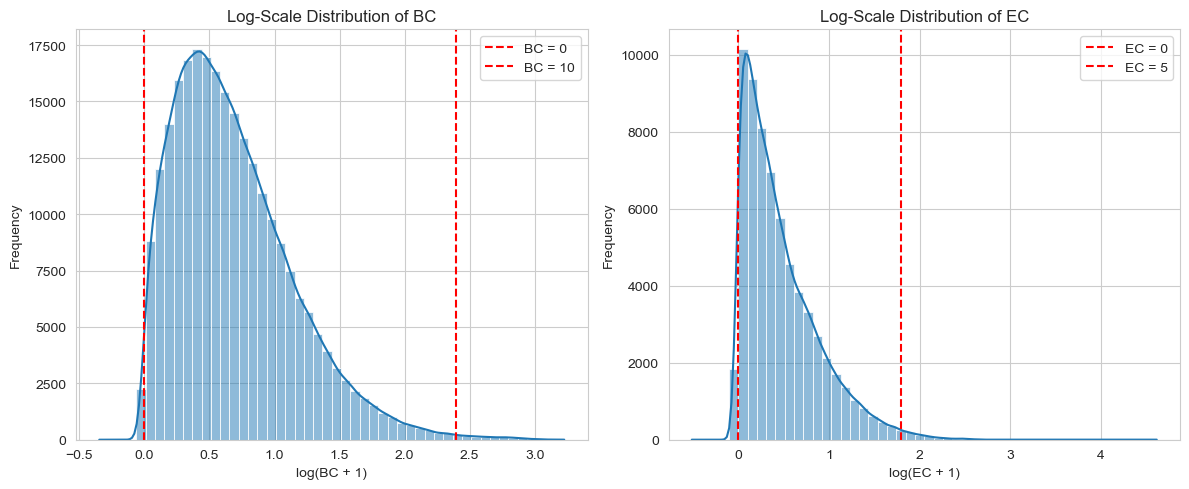

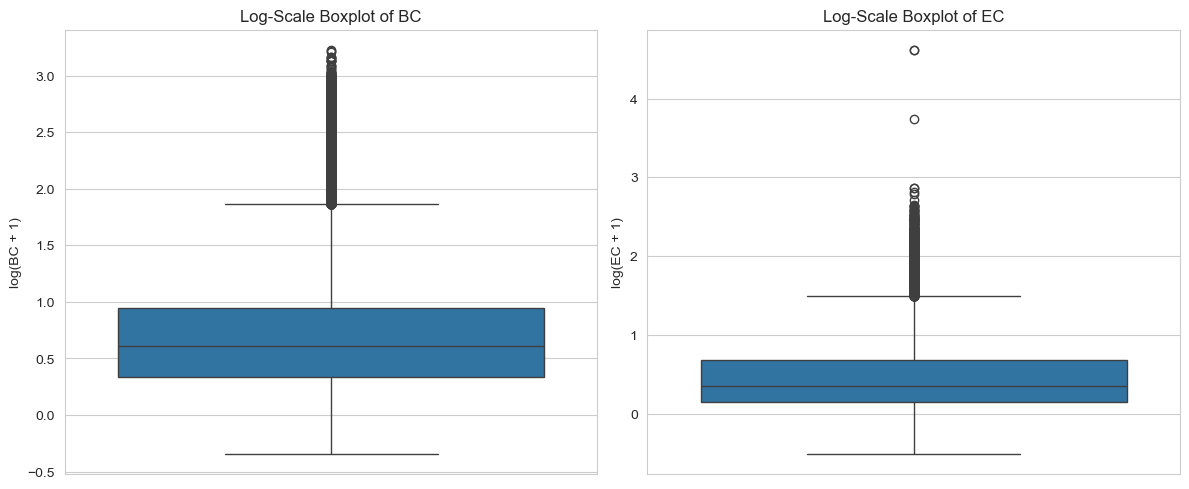

In [18]:
# Convertir explicitement en float
df["BC"] = pd.to_numeric(df["BC"], errors='coerce')
df["EC"] = pd.to_numeric(df["EC"], errors='coerce')

# Puis appliquer la transformation
df["log_BC"] = np.log1p(df["BC"])
df["log_EC"] = np.log1p(df["EC"])

# Define the normal bounds (after log transformation)
bc_lower = np.log1p(0)
bc_upper = np.log1p(10)

ec_lower = np.log1p(0)
ec_upper = np.log1p(5)

# Histograms with bounds
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograms for BC and EC
sns.histplot(df["log_BC"].dropna(), bins=50, kde=True, ax=axes[0])
axes[0].axvline(bc_lower, color='red', linestyle='--', label='BC = 0')
axes[0].axvline(bc_upper, color='red', linestyle='--', label='BC = 10')
axes[0].set_title("Log-Scale Distribution of BC")
axes[0].set_xlabel("log(BC + 1)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

sns.histplot(df["log_EC"].dropna(), bins=50, kde=True, ax=axes[1])
axes[1].axvline(ec_lower, color='red', linestyle='--', label='EC = 0')
axes[1].axvline(ec_upper, color='red', linestyle='--', label='EC = 5')
axes[1].set_title("Log-Scale Distribution of EC")
axes[1].set_xlabel("log(EC + 1)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

# Boxplots for BC and EC Boxplots 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df["log_BC"].dropna(), ax=axes[0])
axes[0].set_title("Log-Scale Boxplot of BC")
axes[0].set_ylabel("log(BC + 1)")

sns.boxplot(y=df["log_EC"].dropna(), ax=axes[1])
axes[1].set_title("Log-Scale Boxplot of EC")
axes[1].set_ylabel("log(EC + 1)")

plt.tight_layout()
plt.show()

The Interquartile Range (IQR) is a robust method for detecting outliers by analyzing the spread of the middle 50% of the data.  
We define:
- Q1 (25th percentile): The value below which 25% of the data falls.
- Q3 (75th percentile): The value below which 75% of the data falls.
- IQR = Q3 - Q1 measures the range of the middle 50% of the dataset.

A data point is considered an outlier if it falls outside the range: [Q1 - 1.5*IQR, Q3 + 1.5*IQR]

Outlier detection for BC:
 - Q1 = 0.4017
 - Q3 = 1.5814
 - IQR = 1.1797
 - Lower bound = -1.3680
 - Upper bound = 3.3510

Outlier detection for EC:
 - Q1 = 0.1621
 - Q3 = 0.9900
 - IQR = 0.8279
 - Lower bound = -1.0797
 - Upper bound = 2.2318

Summary of detected outliers:
 - Total dataset rows: 316951
 - Number of rows identified as outliers: 20936
 - Percentage of BC values considered outliers: 5.07%
 - Percentage of EC values considered outliers: 1.53%



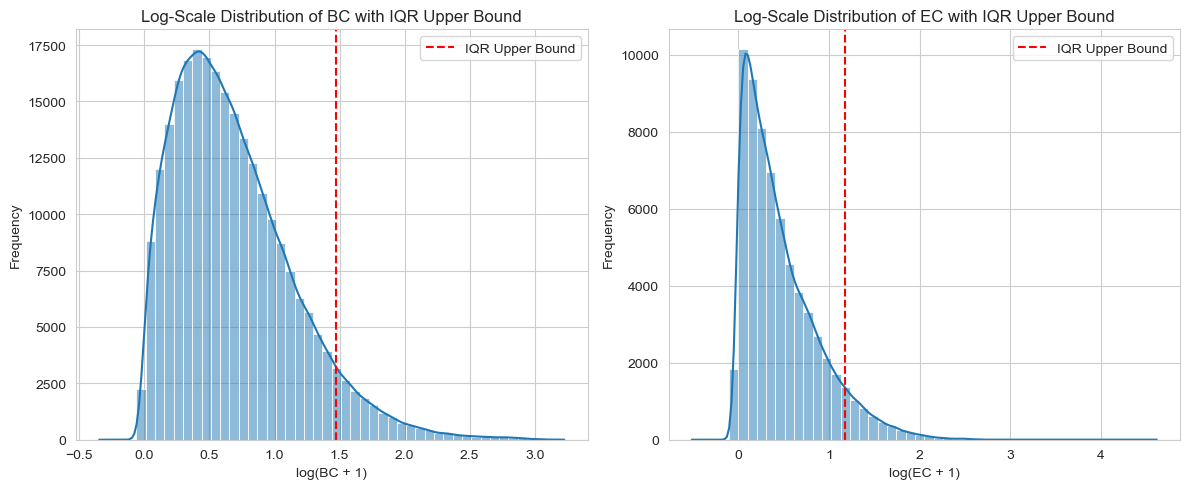

In [20]:
# Apply log(x + 1) to avoid log(0)
df["log_BC"] = np.log1p(df["BC"])
df["log_EC"] = np.log1p(df["EC"])

# Outlier detection function
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)

    print(f"Outlier detection for {column}:")
    print(f" - Q1 = {Q1:.4f}")
    print(f" - Q3 = {Q3:.4f}")
    print(f" - IQR = {IQR:.4f}")
    print(f" - Lower bound = {lower_bound:.4f}")
    print(f" - Upper bound = {upper_bound:.4f}\n")

    return outliers, lower_bound, upper_bound

# Detect outliers in raw scale
outliers_bc, lower_bc, upper_bc = detect_outliers_iqr(df, "BC")
outliers_ec, lower_ec, upper_ec = detect_outliers_iqr(df, "EC")

# Outlier summary
total_rows = df.shape[0]
num_outliers = (outliers_bc | outliers_ec).sum()
percent_outliers_bc = outliers_bc.sum() / total_rows * 100
percent_outliers_ec = outliers_ec.sum() / total_rows * 100

print("Summary of detected outliers:")
print(f" - Total dataset rows: {total_rows}")
print(f" - Number of rows identified as outliers: {num_outliers}")
print(f" - Percentage of BC values considered outliers: {percent_outliers_bc:.2f}%")
print(f" - Percentage of EC values considered outliers: {percent_outliers_ec:.2f}%\n")

# Convert upper bounds to log scale
log_upper_bc = np.log1p(upper_bc)
log_upper_ec = np.log1p(upper_ec)

# Plot log-scale histograms with only upper IQR bound
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for log(BC + 1)
sns.histplot(df["log_BC"].dropna(), bins=50, kde=True, ax=axes[0], color=None)
axes[0].axvline(log_upper_bc, color='red', linestyle='--', label='IQR Upper Bound')
axes[0].set_title("Log-Scale Distribution of BC with IQR Upper Bound")
axes[0].set_xlabel("log(BC + 1)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Histogram for log(EC + 1)
sns.histplot(df["log_EC"].dropna(), bins=50, kde=True, ax=axes[1], color=None)
axes[1].axvline(log_upper_ec, color='red', linestyle='--', label='IQR Upper Bound')
axes[1].set_title("Log-Scale Distribution of EC with IQR Upper Bound")
axes[1].set_xlabel("log(EC + 1)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

Isolation Forest is an unsupervised learning algorithm designed for anomaly detection. It isolates outliers more quickly than normal points by recursively partitioning the dataset. Isolation Forest is fast because it splits the data space, randomly selecting an attribute and split point. The anomaly score is inversely associated with the path-length because anomalies need fewer splits to be isolated, because they are few and different.

Isolation Forest Results:
 - Total dataset rows: 316951
 - Number of rows identified as anomalies: 3158
 - Percentage of anomalies detected: 1.00%



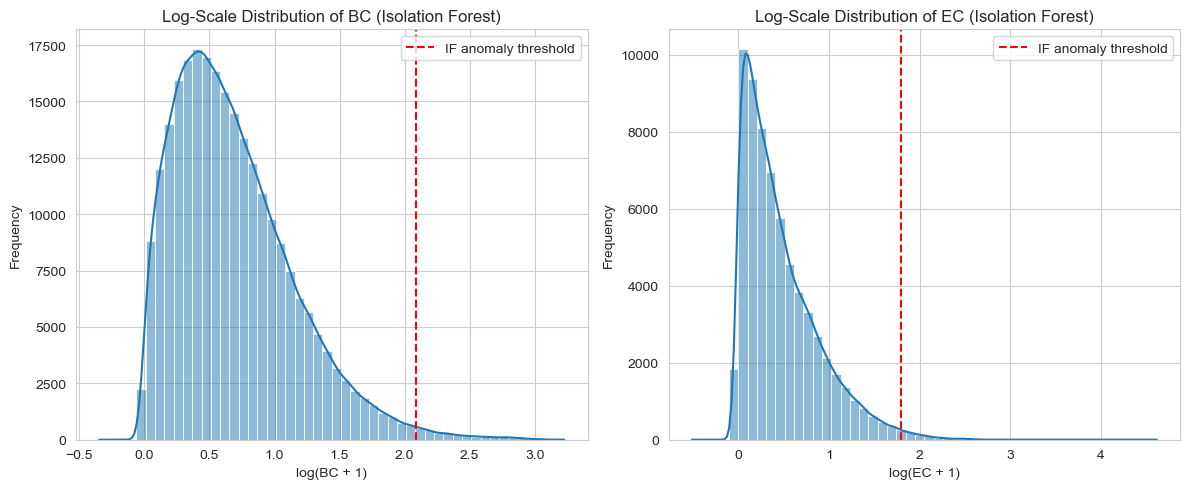

In [24]:
from sklearn.ensemble import IsolationForest

# Apply log(x + 1) if not already done
df["log_BC"] = np.log1p(df["BC"])
df["log_EC"] = np.log1p(df["EC"])

# Prepare data
df_bc = df.dropna(subset=["BC"])[["BC"]].copy()
df_ec = df.dropna(subset=["EC"])[["EC"]].copy()

# Isolation Forest
iso_bc = IsolationForest(contamination=0.01, random_state=42)
df_bc["Anomaly_BC"] = iso_bc.fit_predict(df_bc)

iso_ec = IsolationForest(contamination=0.01, random_state=42)
df_ec["Anomaly_EC"] = iso_ec.fit_predict(df_ec)

# Merge anomaly flags
df_anomaly = df.copy()
df_anomaly = df_anomaly.merge(df_bc["Anomaly_BC"], left_index=True, right_index=True, how="left")
df_anomaly = df_anomaly.merge(df_ec["Anomaly_EC"], left_index=True, right_index=True, how="left")
df_anomaly["Anomaly_BC"] = df_anomaly["Anomaly_BC"].fillna(1)
df_anomaly["Anomaly_EC"] = df_anomaly["Anomaly_EC"].fillna(1)
df_anomaly["Anomaly"] = df_anomaly.apply(lambda row: -1 if row["Anomaly_BC"] == -1 or row["Anomaly_EC"] == -1 else 1, axis=1)

# Filtered dataframe
df_IF = df_anomaly[df_anomaly["Anomaly"] != -1].copy()

# Summary
total_rows = df.shape[0]
num_anomalies = (df_anomaly["Anomaly"] == -1).sum()
percent_anomalies = (num_anomalies / total_rows) * 100

print("Isolation Forest Results:")
print(f" - Total dataset rows: {total_rows}")
print(f" - Number of rows identified as anomalies: {num_anomalies}")
print(f" - Percentage of anomalies detected: {percent_anomalies:.2f}%\n")

# Compute anomaly thresholds
threshold_bc = df_anomaly[df_anomaly["Anomaly_BC"] == -1]["BC"].min()
threshold_ec = df_anomaly[df_anomaly["Anomaly_EC"] == -1]["EC"].min()
log_thresh_bc = np.log1p(threshold_bc)
log_thresh_ec = np.log1p(threshold_ec)

# Plot log-scale histograms with red lines
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# BC histogram
sns.histplot(df["log_BC"].dropna(), bins=50, kde=True, ax=axes[0], color=None)
axes[0].axvline(log_thresh_bc, color='red', linestyle='--', label=f'IF anomaly threshold')
axes[0].set_title("Log-Scale Distribution of BC (Isolation Forest)")
axes[0].set_xlabel("log(BC + 1)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# EC histogram
sns.histplot(df["log_EC"].dropna(), bins=50, kde=True, ax=axes[1], color=None)
axes[1].axvline(log_thresh_ec, color='red', linestyle='--', label=f'IF anomaly threshold')
axes[1].set_title("Log-Scale Distribution of EC (Isolation Forest)")
axes[1].set_xlabel("log(EC + 1)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

For a comparative analysis with outlier detection and predictive modeling, we need to aggregate the data to merge BC and EC values taken at the same station and time.

In [28]:
def merge_colocated_data(df):
    """
    Merge BC and EC measurements from the same station and datetime.
    Handles special cases for different column types, including Flag_MCH.
    """
    # Create copy without excluded columns (keeping Flag_MCH)
    columns_to_drop = ['Instrument', 'EC_BC', 'EC_BC_merged', 'BC_sloped']
    df_colocated = df.drop(columns=columns_to_drop, errors='ignore').copy()
    
    # Separate BC and EC measurements
    df_bc = df_colocated[df_colocated['BC'].notna()].copy()
    df_ec = df_colocated[df_colocated['EC'].notna()].copy()
    
    # Merge on station and datetime
    df_merged = pd.merge(
        df_bc,
        df_ec,
        on=['Station_name', 'Datetime'],
        suffixes=('_bc', '_ec'),
        how='inner'  # Only keep matched pairs
    )
    
    # Conflict resolution functions
    def resolve_text_columns(val1, val2, missing_indicator="UNKNOWN"):
        """For Protocol, Instrument_EC, Instrument_BC (string handling)"""
        val1_str = str(val1) if pd.notna(val1) else None
        val2_str = str(val2) if pd.notna(val2) else None
        
        if val1_str == missing_indicator or val1_str is None:
            return val2
        if val2_str == missing_indicator or val2_str is None:
            return val1
        if val1_str == val2_str:
            return val1
        return f"{val1}, {val2}"
    
    def resolve_numeric_columns(val1, val2, missing_indicator=999.0):
        """For OC, MAC, Size_cut, C_value, H_value (float handling)"""
        if pd.isna(val1) or (isinstance(val1, (int, float)) and np.isclose(val1, missing_indicator)):
            return val2
        if pd.isna(val2) or (isinstance(val2, (int, float)) and np.isclose(val2, missing_indicator)):
            return val1
        if val1 == val2:
            return val1
        return f"{val1}, {val2}"
    
    def resolve_flag_mch(val1, val2):
        """Special handling for Flag_MCH"""
        if pd.isna(val1) and pd.isna(val2):
            return np.nan
        if pd.isna(val1):
            return val2
        if pd.isna(val2):
            return val1
        if val1 == val2:
            return val1
        return f"{val1}, {val2}"
    
    # Build the final dataframe
    df_colocated = pd.DataFrame({
        # Key columns (single value)
        'Station_name': df_merged['Station_name'],
        'ID': df_merged['ID_bc'],  # Must be identical
        'Datetime': df_merged['Datetime'],
        
        # Direct merged values
        'BC': df_merged['BC_bc'],
        'EC': df_merged['EC_ec'],
        
        # Text columns with "UNKNOWN" handling
        'Protocol': [resolve_text_columns(r['Protocol_bc'], r['Protocol_ec']) for _, r in df_merged.iterrows()],
        'Instrument_EC': [resolve_text_columns(r['Instrument_EC_bc'], r['Instrument_EC_ec']) for _, r in df_merged.iterrows()],
        'Instrument_BC': [resolve_text_columns(r['Instrument_BC_bc'], r['Instrument_BC_ec']) for _, r in df_merged.iterrows()],
        
        # Numeric columns with 999.0 handling (as float)
        'OC': [resolve_numeric_columns(r['OC_bc'], r['OC_ec']) for _, r in df_merged.iterrows()],
        'MAC': [resolve_numeric_columns(r['MAC_bc'], r['MAC_ec']) for _, r in df_merged.iterrows()],
        'Size_cut': [resolve_numeric_columns(r['Size_cut_bc'], r['Size_cut_ec']) for _, r in df_merged.iterrows()],
        'C_value': [resolve_numeric_columns(r['C_value_bc'], r['C_value_ec']) for _, r in df_merged.iterrows()],
        'H_value': [resolve_numeric_columns(r['H_value_bc'], r['H_value_ec']) for _, r in df_merged.iterrows()],
        
        # Flag_MCH handling (BC, EC)
        'Flag_MCH': [resolve_flag_mch(r['Flag_MCH_bc'], r['Flag_MCH_ec']) for _, r in df_merged.iterrows()]
    })
    
    return df_colocated

# Execute the merging
df_colocated = merge_colocated_data(df)

# Ensure the 'Datetime' column is in the correct format
df_colocated['Datetime'] = pd.to_datetime(df_colocated['Datetime'])

# Verification
print(f"Number of colocated measurements: {len(df_colocated)}")
display(df_colocated)

# Optional export
df_colocated.to_csv('dataset/df_colocated.csv', index=False)

Number of colocated measurements: 18750


,Station_name,ID,Datetime,BC,EC,Protocol,Instrument_EC,Instrument_BC,OC,MAC,Size_cut,C_value,H_value,Flag_MCH
0,Genova-Bolzaneto,ID332,2011-07-08 00:00:00+00:00,1.326122,1.339383,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,1.0,999.0,1.0,1.0
1,Genova-Bolzaneto,ID332,2011-07-10 00:00:00+00:00,1.684976,1.701826,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,1.0,999.0,1.0,1.0
2,Genova-Bolzaneto,ID332,2011-07-12 00:00:00+00:00,2.267457,2.290131,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,1.0,999.0,1.0,1.0
3,Genova-Bolzaneto,ID332,2011-07-14 00:00:00+00:00,1.468050,1.482731,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,1.0,999.0,1.0,1.0
4,Genova-Bolzaneto,ID332,2011-07-19 00:00:00+00:00,0.968671,0.978358,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,1.0,999.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18745,Zürich-Kaserne,ID824,2019-05-21 00:00:00+00:00,0.530055,0.330000,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"
18746,Zürich-Kaserne,ID824,2019-05-25 00:00:00+00:00,0.734779,0.360000,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"
18747,Zürich-Kaserne,ID824,2019-05-25 00:00:00+00:00,0.734779,0.430000,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"
18748,Zürich-Kaserne,ID824,2019-05-29 00:00:00+00:00,0.322787,0.230000,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"


Let's check that the merging is done correctly with a simple example for the Zurich-Kaserne station, on the date 2019-01-25 00:00:00+00:00.

In [31]:
# Filter rows for both DataFrames based on the specified condition
test_df = df[
    (df['Station_name'] == 'Zürich-Kaserne') &
    (df['Datetime'] == pd.Timestamp('2019-01-25 00:00:00+00:00'))
]

test_df_colocated = df_colocated[
    (df_colocated['Station_name'] == 'Zürich-Kaserne') &
    (df_colocated['Datetime'] == pd.Timestamp('2019-01-25 00:00:00+00:00'))
]

# Display the two filtered DataFrames one after the other
display(test_df)
display(test_df_colocated)

,Station_name,ID,Datetime,Instrument,Protocol,EC_BC,EC_BC_merged,BC,EC,Instrument_EC,Instrument_BC,OC,MAC,Size_cut,C_value,H_value,BC_sloped,Flag_MCH,log_BC,log_EC
65650,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,HVol_Filters,EUSAAR,0,0.480000,NaN,0.48,HVol_Filters,UNKNOWN,999.0,999.0,1.00,999.0,999.0,NaN,1.00,NaN,0.392042
65738,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,HVol_Filters,EUSAAR,0,0.540000,NaN,0.54,HVol_Filters,UNKNOWN,999.0,999.0,1.00,999.0,999.0,NaN,1.00,NaN,0.431782
312239,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,AE33,UNKNOWN,1,0.476197,0.476197,NaN,UNKNOWN,AE,999.0,1.4,1.76,1.4,1.8,0.323944,1.76,0.389469,NaN
315880,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,AE33,UNKNOWN,1,0.823429,0.823429,NaN,UNKNOWN,AE,999.0,1.4,1.76,1.4,1.8,0.560156,1.76,0.600719,NaN


,Station_name,ID,Datetime,BC,EC,Protocol,Instrument_EC,Instrument_BC,OC,MAC,Size_cut,C_value,H_value,Flag_MCH
18421,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,0.476197,0.48,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"
18422,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,0.476197,0.54,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"
18688,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,0.823429,0.48,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"
18689,Zürich-Kaserne,ID824,2019-01-25 00:00:00+00:00,0.823429,0.54,EUSAAR,HVol_Filters,AE,999.0,1.4,"1.76, 1.0",1.4,1.8,"1.76, 1.0"


Let examine the quality of the aggregation.

In [34]:
# Count the occurrences of each value in the 'Protocol' column
protocol_counts = df_colocated['Protocol'].value_counts(dropna=False)

# Display results in the desired format
print("Protocol Occurrences :")
for protocol, count in protocol_counts.items():
    print(f"- {protocol} : {count} rows")

Protocol Occurrences :
- EUSAAR : 9333 rows
- NIOSH : 7650 rows
- UNKNOWN : 1767 rows


The multivariate implementation of the isolation forest could allow for the detection of joint anomalies, since, unlike previously, in multidimensional applications, the isolation forest will take into account interactions between variables and will better detect inconsistent points in the EC ~ BC relationship.

Isolation Forest Results : 
- Total points analyzed     : 18,750
- Number of anomalies found : 188
- Percentage of anomalies   : 1.00%


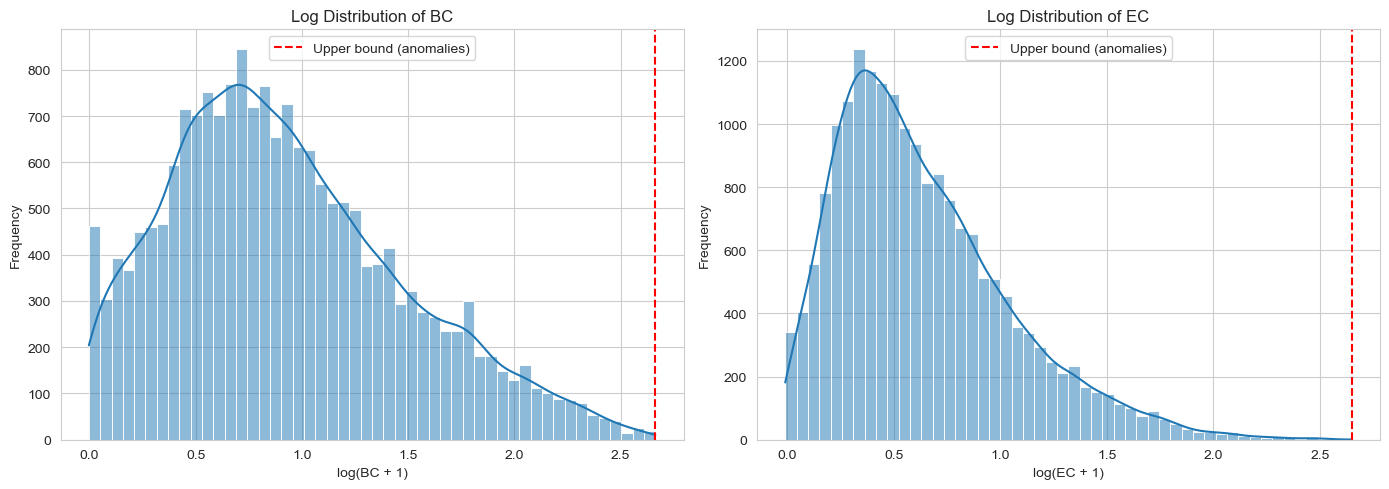

In [36]:
# Assume df_colocated is already defined and contains both BC and EC without NaNs
df_IF_2 = df_colocated.dropna(subset=["BC", "EC"])[["BC", "EC"]].copy()

# Apply log(x + 1)
df_IF_2["log_BC"] = np.log1p(df_IF_2["BC"])
df_IF_2["log_EC"] = np.log1p(df_IF_2["EC"])

# Fit Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
df_IF_2["Anomaly"] = iso.fit_predict(df_IF_2[["log_BC", "log_EC"]])

# Summary stats
total_points = df_IF_2.shape[0]
num_anomalies = (df_IF_2["Anomaly"] == -1).sum()
percent_anomalies = (num_anomalies / total_points) * 100

# Elegant print
print("Isolation Forest Results : ")
print(f"- Total points analyzed     : {total_points:,}")
print(f"- Number of anomalies found : {num_anomalies:,}")
print(f"- Percentage of anomalies   : {percent_anomalies:.2f}%")

# Compute lower bounds (i.e., min values of anomalies)
log_bc_upper = df_IF_2.loc[df_IF_2["Anomaly"] == -1, "log_BC"].max()
log_ec_upper = df_IF_2.loc[df_IF_2["Anomaly"] == -1, "log_EC"].max()

# Plot histograms with red lower bound lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_IF_2["log_BC"], bins=50, kde=True, ax=axes[0])
axes[0].axvline(log_bc_upper, color='red', linestyle='--', label='Upper bound (anomalies)')
axes[0].set_title("Log Distribution of BC")
axes[0].set_xlabel("log(BC + 1)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

sns.histplot(df_IF_2["log_EC"], bins=50, kde=True, ax=axes[1])
axes[1].axvline(log_ec_upper, color='red', linestyle='--', label='Upper bound (anomalies)')
axes[1].set_title("Log Distribution of EC")
axes[1].set_xlabel("log(EC + 1)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

To detect outliers in our dataset, we can also apply Quantile Regression, which models the conditional distribution of BC given EC at different quantiles. The model is optimized using the Pinball Loss function, which asymmetrically penalizes over- and under-predictions. This is useful to establish upper and lower bounds beyond which values are considered outliers.

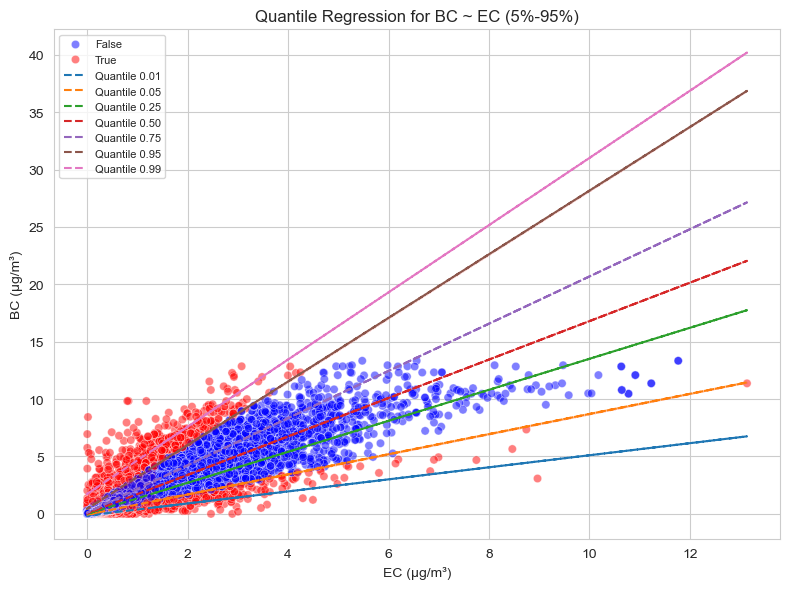

In [39]:
import statsmodels.api as sm

# Prepare the data
df_filtered = df_colocated.dropna(subset=["BC", "EC"]).copy()
X = sm.add_constant(df_filtered["EC"])
y = df_filtered["BC"]

# Define the quantiles to calculate
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df_preds = pd.DataFrame({"EC": df_filtered["EC"]})

# Fit the quantile regressions
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    df_preds[q] = model.predict(X)

# Calculate bounds and detect outliers
df_filtered["Lower_05_95"] = df_preds[0.05]
df_filtered["Upper_05_95"] = df_preds[0.95]
df_filtered["Outlier_05_95"] = ((df_filtered["BC"] < df_filtered["Lower_05_95"]) | (df_filtered["BC"] > df_filtered["Upper_05_95"]))

df_filtered["Lower_01_99"] = df_preds[0.01]
df_filtered["Upper_01_99"] = df_preds[0.99]
df_filtered["Outlier_01_99"] = ((df_filtered["BC"] < df_filtered["Lower_01_99"]) | (df_filtered["BC"] > df_filtered["Upper_01_99"]))

# Display only the 5%-95% plot
plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.scatterplot(
    ax=ax, x=df_filtered["EC"], y=df_filtered["BC"],
    hue=df_filtered["Outlier_05_95"], palette={True: "red", False: "blue"},
    alpha=0.5
)
for q in quantiles:
    ax.plot(df_preds["EC"], df_preds[q], linestyle="dashed", label=f"Quantile {q:.2f}")
ax.fill_between(df_preds["EC"], df_preds[0.05], df_preds[0.95], color='red', alpha=0.1)
ax.set_title("Quantile Regression for BC ~ EC (5%-95%)")
ax.set_xlabel("EC (µg/m³)")
ax.set_ylabel("BC (µg/m³)")
ax.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

Any BC measurement outside the 5%-95% range was flagged as an outlier. The plot displays regression quantile lines at different levels and the outlier detection region. Points far to the right are not considered outliers because the goal of quantile regression is not to detect high absolute values, but rather to see if a BC value is abnormally high or low given the EC value. So, even if a point seems extreme in absolute value, it will not be considered an outlier if it is consistent with the model trend. And in our case, this point corresponds to an exception, that is why it is not detected as an outlier.

In [42]:
# Summary of outlier detection results
total_points = len(df_filtered)

num_outliers_05_95 = df_filtered["Outlier_05_95"].sum()
percent_outliers_05_95 = (num_outliers_05_95 / total_points) * 100

num_outliers_01_99 = df_filtered["Outlier_01_99"].sum()
percent_outliers_01_99 = (num_outliers_01_99 / total_points) * 100

print("Based on 5%-95% quantile bounds:")
print(f" - Total data points analyzed: {total_points}")
print(f" - Number of outliers detected: {num_outliers_05_95}")
print(f" - Percentage of outliers detected: {percent_outliers_05_95:.2f}%")

print("Based on 1%-99% quantile bounds:")
print(f" - Total data points analyzed: {total_points}")
print(f" - Number of outliers detected: {num_outliers_01_99}")
print(f" - Percentage of outliers detected: {percent_outliers_01_99:.2f}%")

Based on 5%-95% quantile bounds:
 - Total data points analyzed: 18750
 - Number of outliers detected: 1876
 - Percentage of outliers detected: 10.01%
Based on 1%-99% quantile bounds:
 - Total data points analyzed: 18750
 - Number of outliers detected: 376
 - Percentage of outliers detected: 2.01%


Let us move on to the analysis of the influence of protocols on the EC/BC relationship, which is essential to identify potential systematic biases due to protocols and thus build reliable prediction models. We therefore seek to determine whether the differences observed between Elemental Carbon (EC) and Black Carbon (BC) measurements can be explained by the measurement protocols used. We use the variable log_ratio = log(EC / BC) to assess the relative differences between EC and BC.

In [44]:
# Start from the dataframe filtered by Quantile Regression 5%-95%
df_filtered = df_filtered[(~df_filtered["Outlier_05_95"])].copy()

# Keep the lines with EC > 0 and BC > 0
df_filtered = df_filtered[(df_filtered["EC"] > 0) & (df_filtered["BC"] > 0)].copy()

# Calculation of the EC/BC log ratio
df_filtered["log_ratio"] = np.log(df_filtered["EC"] / df_filtered["BC"])

# Print results
display(df_filtered.head())

,Station_name,ID,Datetime,BC,EC,Protocol,Instrument_EC,Instrument_BC,OC,MAC,...,C_value,H_value,Flag_MCH,Lower_05_95,Upper_05_95,Outlier_05_95,Lower_01_99,Upper_01_99,Outlier_01_99,log_ratio
0,Genova-Bolzaneto,ID332,2011-07-08 00:00:00+00:00,1.326122,1.339383,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,...,999.0,1.0,1.0,1.110652,4.163926,False,0.559825,5.664333,False,0.00995
1,Genova-Bolzaneto,ID332,2011-07-10 00:00:00+00:00,1.684976,1.701826,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,...,999.0,1.0,1.0,1.428328,5.167981,False,0.750096,6.724772,False,0.00995
2,Genova-Bolzaneto,ID332,2011-07-12 00:00:00+00:00,2.267457,2.290131,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,...,999.0,1.0,1.0,1.943969,6.797728,False,1.058938,8.446037,False,0.00995
3,Genova-Bolzaneto,ID332,2011-07-14 00:00:00+00:00,1.468050,1.482731,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,...,999.0,1.0,1.0,1.236294,4.561034,False,0.635078,6.083741,False,0.00995
4,Genova-Bolzaneto,ID332,2011-07-19 00:00:00+00:00,0.968671,0.978358,UNKNOWN,UNKNOWN,MAAP,999.0,999.0,...,999.0,1.0,1.0,0.794219,3.163801,False,0.370298,4.608045,False,0.00995


Visualizing the log_ratio distribution can allows us to quickly gain insight into the relationship between EC and BC, detect anomalies, and decide whether additional processing is needed to prepare the data before applying more complex models or analyses.

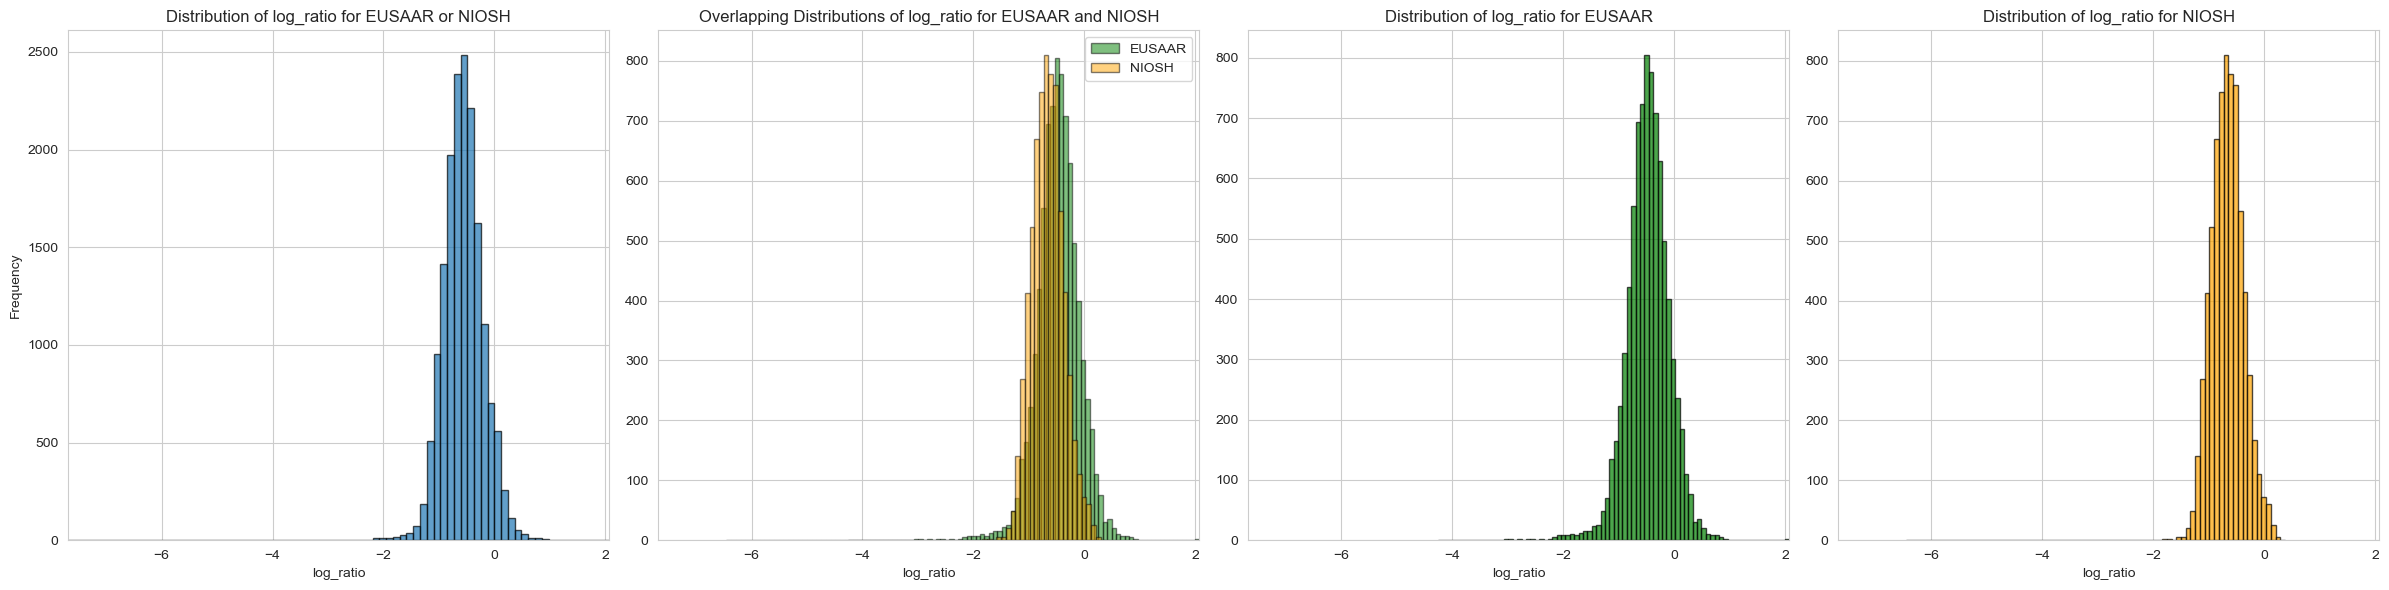

In [47]:
# Create a figure with 4 subgraphs side by side
fig, ax = plt.subplots(1, 4, figsize=(24, 6))  # Ajusté à 4 sous-graphes

# Global histogram of log_ratio values distribution
ax[0].hist(df_filtered['log_ratio'].dropna(), bins=80, edgecolor='black', alpha=0.7)
ax[0].set_title('Distribution of log_ratio for EUSAAR or NIOSH')
ax[0].set_xlabel('log_ratio')
ax[0].set_ylabel('Frequency')

# Histogram with EUSAAR and NIOSH overlaid
eusaar_data = df_filtered[df_filtered['Protocol'] == 'EUSAAR']['log_ratio'].dropna()
niosh_data = df_filtered[df_filtered['Protocol'] == 'NIOSH']['log_ratio'].dropna()
ax[1].hist(eusaar_data, bins=80, edgecolor='black', alpha=0.5, label='EUSAAR', color='green')
ax[1].hist(niosh_data, bins=80, edgecolor='black', alpha=0.5, label='NIOSH', color='orange')
ax[1].set_title('Overlapping Distributions of log_ratio for EUSAAR and NIOSH')
ax[1].set_xlabel('log_ratio')
ax[1].legend()

# Histogram for EUSAAR
ax[2].hist(eusaar_data, bins=80, edgecolor='black', alpha=0.7, color='green')
ax[2].set_title('Distribution of log_ratio for EUSAAR')
ax[2].set_xlabel('log_ratio')

# Histogram for NIOSH
ax[3].hist(niosh_data, bins=80, edgecolor='black', alpha=0.7, color='orange')
ax[3].set_title('Distribution of log_ratio for NIOSH')
ax[3].set_xlabel('log_ratio')

# Adjust x-axis limits for better comparison
for axis in ax:
    axis.set_xlim(df_filtered['log_ratio'].min(), df_filtered['log_ratio'].max())

plt.tight_layout()
plt.show()

The majority of values ​​are negative, so we can conclude that EC is generally lower than BC. Also, values ​​close to zero suggest a balance and strong similarity between EC and BC. However, the few extreme values ​​observed should be examined to detect anomalies or special cases.

In [50]:
# Filter the rows where log_ratio is less than -2
df_inconsistencies = df_filtered[df_filtered['log_ratio'] < -2]

# Display the number of corresponding rows
print(f"Number of corresponding rows: {df_inconsistencies.shape[0]}")

Number of corresponding rows: 46


ANOVA allows testing whether the log_ratio variable varies significantly across different protocols (log(EC / BC) ~ Protocole). We therefore want to know if the measurement protocol systematically influences the EC/BC ratio.

In [53]:
import scipy.stats as stats

# Log_ratio groups per protocol
groups = [group["log_ratio"].values for _, group in df_filtered.groupby("Protocol")]

# ANOVA Test
f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA on log(EC / BC) ~ Protocol")
print(f" - F-statistic : {f_stat:.4f}")
print(f" - p-value     : {p_value:.4e}")

if p_value < 0.05:
    print("Since the p-value < 0.05, there is a significant difference between the protocols.")
else:
    print("Since the p-value > 0.05, there is no significant difference detected between protocols.")

ANOVA on log(EC / BC) ~ Protocol
 - F-statistic : 474.1468
 - p-value     : 4.7013e-201
Since the p-value < 0.05, there is a significant difference between the protocols.


The high F-statistic obtained means that the variability of the log(EC/BC) between protocols is very high compared to the variability within each protocol. While the p-value obtained quasi equal to zero confirms that this difference is statistically significant. Then, we can conclude with certainty that the measurement protocol has a significant effect on the EC/BC ratio. It will therefore be necessary to take the protocol into account in the harmonization prediction models. 

To more precisely quantify the effect of each protocol on the EC/BC ratio compared to a reference protocol (here, UNKNOWN), we performed a linear regression with dummy variables.

In [56]:
import statsmodels.formula.api as smf

# Regression with automatic dummies for the categorical variable "Protocol" with 'UNKNOWN' as reference
model = smf.ols('log_ratio ~ C(Protocol, Treatment("UNKNOWN"))', data=df_filtered).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_ratio   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     474.1
Date:                Sat, 31 May 2025   Prob (F-statistic):          4.70e-201
Time:                        23:41:42   Log-Likelihood:                -7261.4
No. Observations:               16835   AIC:                         1.453e+04
Df Residuals:                   16832   BIC:                         1.455e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

We therefore modeled : log(EC/BC) = a + b * dummy_EUSAAR + c * dummy_NIOSH + ε ; where :
- a = mean value of log(EC/BC) when the protocol is EUSAAR2 (the reference category).
- b = mean difference between EUSAAR and UNKNOWN.
- c = mean difference between NIOSH and UNKNOWN.

The results are as follows :
- Intercept (UNKNOWN) : -0.6034, which is the mean value of log(EC/BC) when the protocol is UNKNOWN.
- T.EUSAAR : 0.1238, which means that the log ratio is on average 0.1238 units upper than UNKNOWN under EUSAAR.
- T.NIOSH : -0.0613, which means that the log ratio is on average 0.0613 units lower than UNKNOWN under NIOSH.

And the p-values are all < 0.05, therefore highly significant. This means that these effects are statistically reliable.

Therefore :
- UNKNOWN : log(EC/BC) ≈ -0.60 → EC is slightly lower than BC (because exp(-0.60) ≈ 0.55 → EC ≈ 0.55 × BC).
- EUSAAR : log(EC/BC) ≈ -0.60 + 0.12 ≈ -0.48 → EC is lower than BC (exp(−0.48) ≈ 0.62 → EC ≈ 0.62 × BC).
- NIOSH : log(EC/BC) ≈ -0.60 − 0.06 ≈ -0.66 → EC is lower than BC (exp(−0.66) ≈ 0.51 → EC ≈ 0.51 × BC).

Therefore, we have statistical evidence that the protocol influences the EC/BC ratio and that the protocol should be included as an explanatory variable in future predictive models. 

To compare how each protocol influences the structure of the EC ~ BC relationship at the mean (OLS) and at the median (quantile regression) we will complement the analysis by modeling the EC-BC relationship directly using Ordinary Least Squares (OLS) regressions and Quantile Regression (q = 0.5) separately for each protocol, in order to validate our earlier findings.

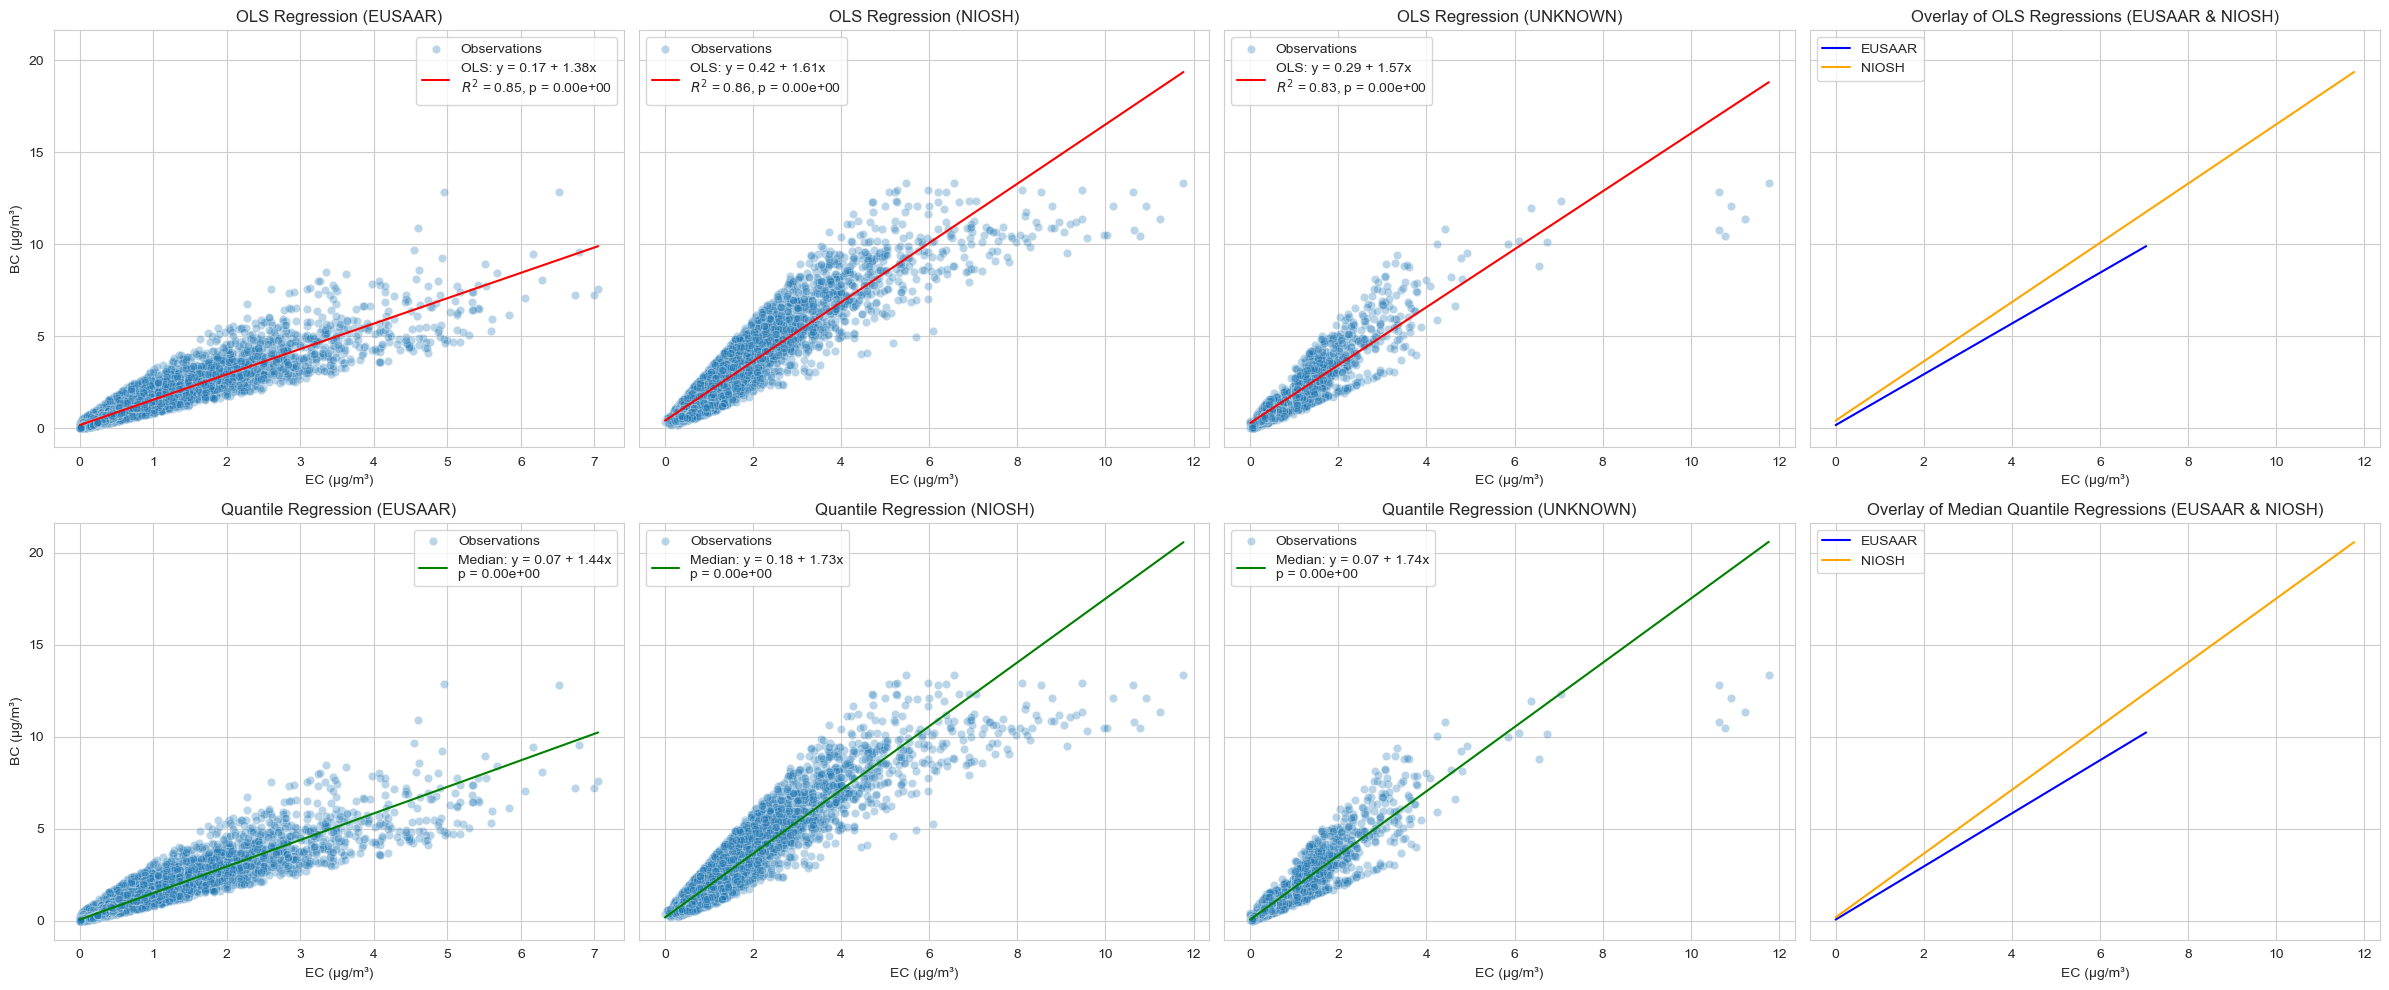

In [59]:
# Set up protocol labels
protocol_labels = {"EUSAAR": "EUSAAR", "NIOSH": "NIOSH", "UNKNOWN": "UNKNOWN"}
colors = {"EUSAAR": "blue", "NIOSH": "orange", "UNKNOWN": "purple"}

# Create figure with 2 rows (OLS and Quantile) and 4 columns (3 protocols + 1 overlay)
fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)

# Prepare for overlay (only EUSAAR and NIOSH)
overlay_data = {"OLS": [], "Quantile": []}

for i, proto in enumerate(["EUSAAR", "NIOSH", "UNKNOWN"]):
    # Filter data for current protocol
    df_proto = df_filtered[df_filtered["Protocol"] == proto].dropna(subset=["EC", "BC"])
    
    if df_proto.empty:
        continue

    # OLS Regression
    X = sm.add_constant(df_proto["EC"])  # Add intercept term
    y = df_proto["BC"]
    ols_model = sm.OLS(y, X).fit()
    intercept_ols, slope_ols = ols_model.params
    r2_ols = ols_model.rsquared
    pval_ols = ols_model.pvalues["EC"]

    # Plot OLS results
    ax = axes[0, i]
    sns.scatterplot(x="EC", y="BC", data=df_proto, ax=ax, alpha=0.3, label="Observations")
    x_vals = np.linspace(df_proto["EC"].min(), df_proto["EC"].max(), 100)
    ax.plot(x_vals, intercept_ols + slope_ols * x_vals, color="red", 
            label=f"OLS: y = {intercept_ols:.2f} + {slope_ols:.2f}x\n$R^2$ = {r2_ols:.2f}, p = {pval_ols:.2e}")
    ax.set_title(f"OLS Regression ({protocol_labels[proto]})")
    ax.set_xlabel("EC (µg/m³)")
    if i == 0:
        ax.set_ylabel("BC (µg/m³)")
    ax.legend()

    # Add to overlay data only if proto is not UNKNOWN
    if proto != "UNKNOWN":
        overlay_data["OLS"].append((x_vals, intercept_ols + slope_ols * x_vals, protocol_labels[proto], colors[proto]))

    # Quantile Regression (Median)
    qr_model = smf.quantreg("BC ~ EC", df_proto).fit(q=0.5)
    intercept_qr, slope_qr = qr_model.params
    pval_qr = qr_model.pvalues["EC"]

    # Plot Quantile results
    ax = axes[1, i]
    sns.scatterplot(x="EC", y="BC", data=df_proto, ax=ax, alpha=0.3, label="Observations")
    ax.plot(x_vals, intercept_qr + slope_qr * x_vals, color="green", 
            label=f"Median: y = {intercept_qr:.2f} + {slope_qr:.2f}x\np = {pval_qr:.2e}")
    ax.set_title(f"Quantile Regression ({protocol_labels[proto]})")
    ax.set_xlabel("EC (µg/m³)")
    if i == 0:
        ax.set_ylabel("BC (µg/m³)")
    ax.legend()

    # Add to overlay data only if proto is not UNKNOWN
    if proto != "UNKNOWN":
        overlay_data["Quantile"].append((x_vals, intercept_qr + slope_qr * x_vals, protocol_labels[proto], colors[proto]))

# Plot overlay for OLS (EUSAAR & NIOSH only)
ax = axes[0, 3]
for x_vals, y_vals, label, color in overlay_data["OLS"]:
    ax.plot(x_vals, y_vals, label=f"{label}", color=color)
ax.set_title("Overlay of OLS Regressions (EUSAAR & NIOSH)")
ax.set_xlabel("EC (µg/m³)")
ax.legend()
ax.grid(True)

# Plot overlay for Quantile (EUSAAR & NIOSH only)
ax = axes[1, 3]
for x_vals, y_vals, label, color in overlay_data["Quantile"]:
    ax.plot(x_vals, y_vals, label=f"{label}", color=color)
ax.set_title("Overlay of Median Quantile Regressions (EUSAAR & NIOSH)")
ax.set_xlabel("EC (µg/m³)")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

The two sets of visualizations above provide linear (OLS) and quantile (q=0.5) regressions of BC as a function of EC, split by measurement protocol. Ordinary Least Squares (OLS) regression minimizes the squared differences between observed and predicted values, making it sensitive to outliers and skewed distributions. Quantile Regression, on the other hand, minimizes the pinball loss, making it more robust to outliers. So, the OLS regression provides a baseline linear relationship, giving us the average behavior of BC for a given EC within each protocol, while the quantile regression at q=0.5 is used as a robust alternative that is less affected by outliers.

The results of the per-protocol regressions align perfectly with the conclusions drawn from our previous statistical analyses. Because the regressions show different slopes depending on the protocol, this corresponds to a systematic variation in the EC/BC ratio confirmed by the ANOVA.

Let's move on to a statistical analysis of instruments using the Kruskal-Wallis Test to assess whether :
- BC (Black Carbon) measurements differ significantly across instruments (Instrument_BC).
- EC (Elemental Carbon) measurements differ significantly across instruments (Instrument_EC).

This test evaluates the null hypothesis : "All instruments produce measurements drawn from the same statistical distribution". The Kruskal-Wallis test is a non-parametric method that does not assume:
- Normality : BC/EC data often follow skewed distributions.
- Equal variances : Environmental measurements frequently exhibit heteroscedasticity.
- Interval-scale data : It works with ordinal or non-normally distributed continuous data.

Kruskal-Wallis tests a hypothesis based on the difference in distributions, while ANOVA tests a difference in means. So, unlike ANOVA, which compares means and is sensitive to outliers, Kruskal-Wallis compares ranked distributions, making it robust for real-world environmental datasets.

In [63]:
from scipy.stats import kruskal

# Test for BC across instruments
bc_groups = [group["BC"].values for name, group in df_filtered.groupby("Instrument_BC")]
h_stat_bc, p_val_bc = kruskal(*bc_groups)

# Test for EC across instruments
ec_groups = [group["EC"].values for name, group in df_filtered.groupby("Instrument_EC")]
h_stat_ec, p_val_ec = kruskal(*ec_groups)

print(f"BC results: H = {h_stat_bc:.1f}, p-value = {p_val_bc:.3e}")
print(f"EC results: H = {h_stat_ec:.1f}, p-value = {p_val_ec:.3e}")

BC results: H = 2291.4, p-value = 0.000e+00
EC results: H = 267.8, p-value = 6.923e-59


For Black Carbon (BC), the test yielded an extremely high H-statistic and a p-value effectively equal to zero. These results are highly significant, allowing us to reject the null hypothesis. This means that MAAP instrument produces systematically different BC measurements compared to AE instrument. The difference is not random and likely reflect methodological or technical biases between instruments.

For Elemental Carbon (EC), the H-statistic is also very larg, with an exceptionally small p-value, which is far below the significance threshold. This strongly significant result indicates that EC measurements vary markedly across instruments, particularly between categories like UNKNOWN, LVol_Filters, and Vol_Filters. Such discrepancies suggest instrument sensitivity.

Let's display the violin plots for comparison. These plots visualize the distribution of BC and EC measurements across different instruments, complementing our previous statistical tests.

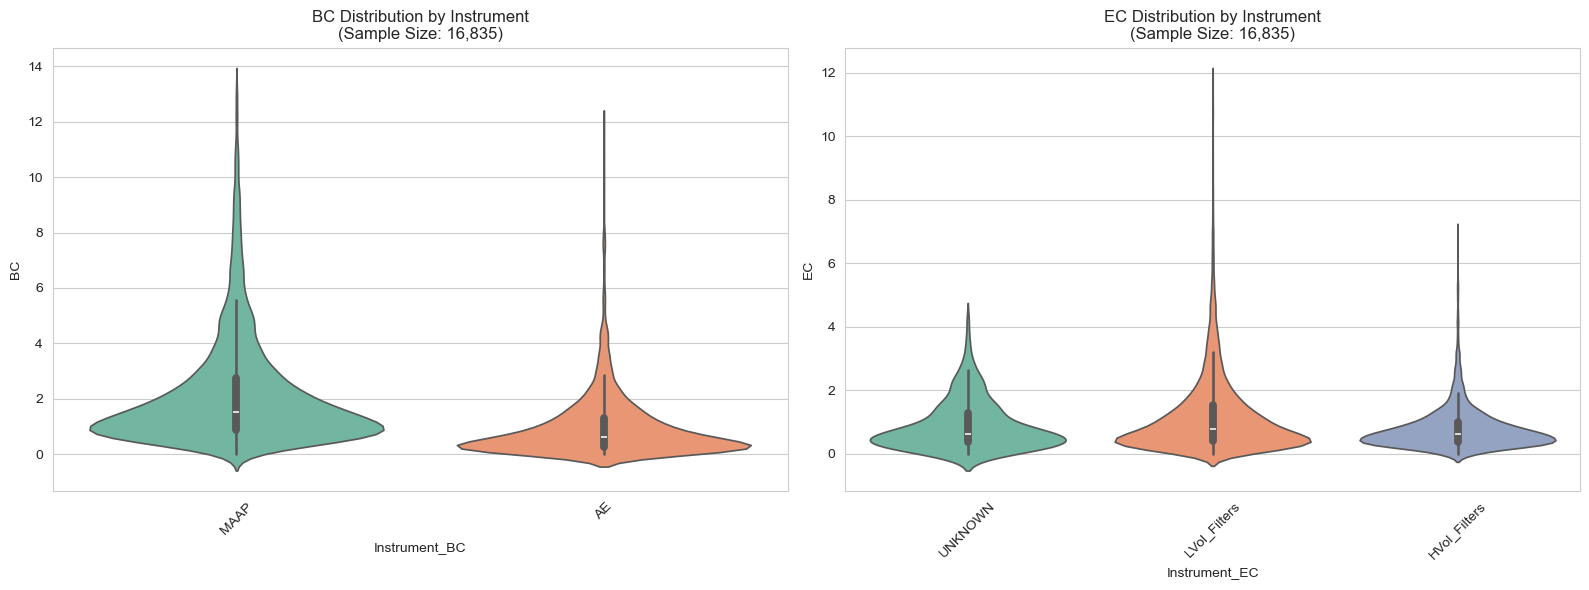

In [66]:
# Create figure
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Violin plot for BC (corrected)
sns.violinplot(
    x="Instrument_BC", 
    y="BC", 
    data=df_filtered,
    hue="Instrument_BC",  # Added to fix warning
    palette="Set2",
    legend=False,          # Avoid duplicate labels
    ax=ax[0]
)
ax[0].set_title("BC Distribution by Instrument\n(Sample Size: 16,835)")
ax[0].tick_params(axis='x', rotation=45)  # Rotate labels

# Violin plot for EC (corrected)
sns.violinplot(
    x="Instrument_EC", 
    y="EC", 
    data=df_filtered,
    hue="Instrument_EC",  # Added to fix warning
    palette="Set2",
    legend=False,          # Avoid duplicate labels
    ax=ax[1]
)
ax[1].set_title("EC Distribution by Instrument\n(Sample Size: 16,835)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The plots we obrained confirm significant instrument-based differences (as seen in the Kruskal-Wallis test). So, these results emphasize the need for instrument-specific corrections in air quality analyses. But, before, let's check the occurrences of our instruments for each concentration measurement.

In [69]:
# Count occurrences for each Instrument column
count_EC = df_filtered['Instrument_EC'].value_counts()
count_BC = df_filtered['Instrument_BC'].value_counts()

# Print the results
print("Occurrences for Instrument_BC:")
print(count_BC)
print("\n")

print("Occurrences for Instrument_EC:")
print(count_EC)
print("\n")

# Count combinations of both Instrument_BC and Instrument_EC
combinaisons_counts = df_filtered.groupby(['Instrument_BC', 'Instrument_EC']).size().reset_index(name='Count')

# Print the combinations
print("Combinations of Instruments_BC:")
print(combinaisons_counts)

Occurrences for Instrument_BC:
Instrument_BC
MAAP    13148
AE       3687
Name: count, dtype: int64


Occurrences for Instrument_EC:
Instrument_EC
LVol_Filters    12173
HVol_Filters     4423
UNKNOWN           239
Name: count, dtype: int64


Combinations of Instruments_BC:
  Instrument_BC Instrument_EC  Count
0            AE  HVol_Filters   2089
1            AE  LVol_Filters   1483
2            AE       UNKNOWN    115
3          MAAP  HVol_Filters   2334
4          MAAP  LVol_Filters  10690
5          MAAP       UNKNOWN    124


In this section, we will visualize the distribution of log_ratio for different categories of Instrument_BC and Instrument_EC. Histograms are particularly useful for observing the frequency distribution of continuous data, and will help us identify any patterns, central tendencies, or outliers in the data before we proceed with any statistical tests. So, this allows us to better understand the data before performing the ANOVA tests.

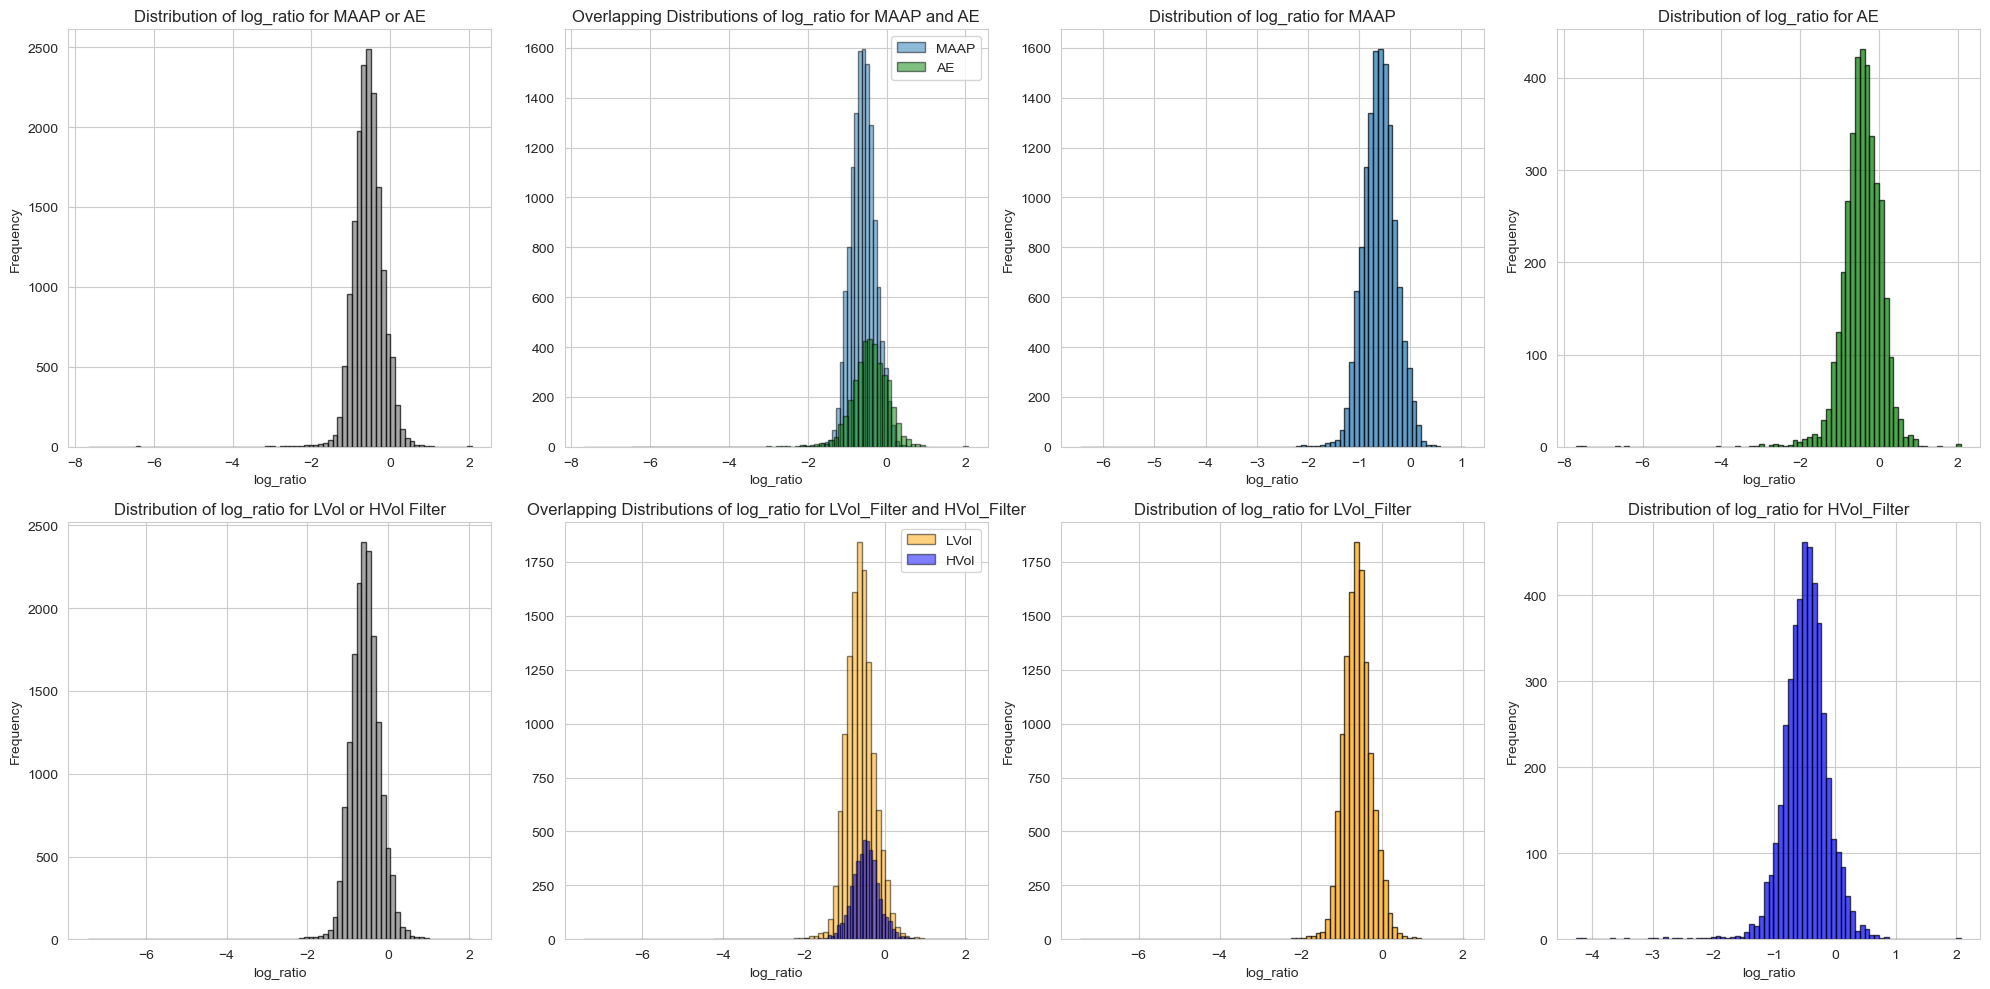

In [72]:
# Create the plot figure with 2x4 layout
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# MAAP or AE only (Union) 
maap_or_ae = df_filtered[df_filtered['Instrument_BC'].isin(['MAAP', 'AE'])]['log_ratio'].dropna()
ax[0, 0].hist(maap_or_ae, bins=80, edgecolor='black', alpha=0.7, color='gray')
ax[0, 0].set_title('Distribution of log_ratio for MAAP or AE')
ax[0, 0].set_xlabel('log_ratio')
ax[0, 0].set_ylabel('Frequency')

# LVol or HVol only (Union) 
lvol_or_hvol = df_filtered[df_filtered['Instrument_EC'].isin(['LVol_Filters', 'HVol_Filters'])]['log_ratio'].dropna()
ax[1, 0].hist(lvol_or_hvol, bins=80, edgecolor='black', alpha=0.7, color='gray')
ax[1, 0].set_title('Distribution of log_ratio for LVol or HVol Filter')
ax[1, 0].set_xlabel('log_ratio')
ax[1, 0].set_ylabel('Frequency')

# Overlay: MAAP vs AE 
maap_data = df_filtered[df_filtered['Instrument_BC'] == 'MAAP']['log_ratio'].dropna()
ae_data = df_filtered[df_filtered['Instrument_BC'] == 'AE']['log_ratio'].dropna()
ax[0, 1].hist(maap_data, bins=80, edgecolor='black', alpha=0.5, label='MAAP')
ax[0, 1].hist(ae_data, bins=80, edgecolor='black', alpha=0.5, color='green', label='AE')
ax[0, 1].set_title('Overlapping Distributions of log_ratio for MAAP and AE')
ax[0, 1].set_xlabel('log_ratio')
ax[0, 1].legend()

# Overlay: LVol vs HVol 
lvol_filter_data = df_filtered[df_filtered['Instrument_EC'] == 'LVol_Filters']['log_ratio'].dropna()
hvol_filter_data = df_filtered[df_filtered['Instrument_EC'] == 'HVol_Filters']['log_ratio'].dropna()
ax[1, 1].hist(lvol_filter_data, bins=80, edgecolor='black', alpha=0.5, color='orange', label='LVol')
ax[1, 1].hist(hvol_filter_data, bins=80, edgecolor='black', alpha=0.5, color='blue', label='HVol')
ax[1, 1].set_title('Overlapping Distributions of log_ratio for LVol_Filter and HVol_Filter')
ax[1, 1].set_xlabel('log_ratio')
ax[1, 1].legend()

# Individual: MAAP
ax[0, 2].hist(maap_data, bins=80, edgecolor='black', alpha=0.7)
ax[0, 2].set_title('Distribution of log_ratio for MAAP')
ax[0, 2].set_xlabel('log_ratio')
ax[0, 2].set_ylabel('Frequency')

# Individual: AE
ax[0, 3].hist(ae_data, bins=80, edgecolor='black', alpha=0.7, color='green')
ax[0, 3].set_title('Distribution of log_ratio for AE')
ax[0, 3].set_xlabel('log_ratio')
ax[0, 3].set_ylabel('Frequency')

# Individual: LVol_Filter
ax[1, 2].hist(lvol_filter_data, bins=80, edgecolor='black', alpha=0.7, color='orange')
ax[1, 2].set_title('Distribution of log_ratio for LVol_Filter')
ax[1, 2].set_xlabel('log_ratio')
ax[1, 2].set_ylabel('Frequency')

# Individual: HVol_Filter
ax[1, 3].hist(hvol_filter_data, bins=80, edgecolor='black', alpha=0.7, color='blue')
ax[1, 3].set_title('Distribution of log_ratio for HVol_Filter')
ax[1, 3].set_xlabel('log_ratio')
ax[1, 3].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

Histograms provide an initial idea of trends in the data. The log ratio graphs all appear similar, regardless of the instrument used, suggesting that there are no major visual differences between groups. However, an ANOVA test is necessary to rigorously and objectively prove whether the differences between groups are statistically significant. This test helps us make data-driven decisions and avoid jumping to conclusions based solely on visual inspection. Thus, ANOVA will allow us to confirm whether the observed differences between groups (MAAP vs. AE and LVol_Filter vs. HVol_Filter) are statistically significant and not due to chance.

We are performing two ANOVA tests (Analysis of Variance) to examine if the type of instruments used (for Instrument_BC and Instrument_EC) significantly impacts the variable log ratio. The ANOVA for Instrument_BC test if there is a significant difference in the means of log ratio between two instruments: MAAP and AE. While, the ANOVA for Instrument_EC test if there is a significant difference in the means of log ratio between two types of Instrument_EC: LVol_Filter and HVol_Filter. Both tests perform a one-way ANOVA (one factor at a time) to assess the differences in means between the groups (the two levels of each factor).

In [75]:
# Filter the data to keep only the relevant instruments
df_filtered_BC = df_filtered[df_filtered['Instrument_BC'].isin(['MAAP', 'AE'])]
df_filtered_EC = df_filtered[df_filtered['Instrument_EC'].isin(['LVol_Filters', 'HVol_Filters'])]

# ANOVA for Instrument_BC (MAAP vs AE)
anova_BC = stats.f_oneway(
    df_filtered_BC[df_filtered_BC['Instrument_BC'] == 'MAAP']['log_ratio'],
    df_filtered_BC[df_filtered_BC['Instrument_BC'] == 'AE']['log_ratio']
)

# ANOVA for Instrument_EC (LVol_Filter vs HVol_Filter)
anova_EC = stats.f_oneway(
    df_filtered_EC[df_filtered_EC['Instrument_EC'] == 'LVol_Filters']['log_ratio'],
    df_filtered_EC[df_filtered_EC['Instrument_EC'] == 'HVol_Filters']['log_ratio']
)

# Display the results
print("ANOVA result for Instrument_BC (MAAP vs AE):")
print("F-statistic =", anova_BC.statistic)
print("p-value =", anova_BC.pvalue)

print("\nANOVA result for Instrument_EC (LVol_Filter vs HVol_Filter):")
print("F-statistic =", anova_EC.statistic)
print("p-value =", anova_EC.pvalue)

ANOVA result for Instrument_BC (MAAP vs AE):
F-statistic = 601.9678735012478
p-value = 1.2201099963164013e-130

ANOVA result for Instrument_EC (LVol_Filter vs HVol_Filter):
F-statistic = 344.0334083703617
p-value = 4.952299381618802e-76


ANOVA for Instrument_BC : The very small p-value (much less than 0.05) indicates that there is a statistically significant difference between the means of log_ratio_BC/EC for MAAP and AE. This suggests that the type of Instrument_BC (either MAAP or AE) has a significant effect on the log_ratio values. The large F-statistic further confirms the strength of the relationship. Thus, we reject the null hypothesis and conclude that there is a significant difference in the means of log_ratio between MAAP and AE. The type of Instrument_BC clearly influences the measured log ratio_BC/EC.

ANOVA for Instrument_EC : Similar to the result for Instrument_BC, the p-value is extremely small, indicating a significant difference between the means of log_ratio for LVol_Filter and HVol_Filter. The F-statistic is also quite large, suggesting that the effect of Instrument_EC is very strong. We reject the null hypothesis for Instrument_EC as well, indicating that the type of filter used has a significant impact on log_ratio. The two instruments lead to different measurements of the log_ratio.

Thus, both tests suggest that the type of instrument used, whether it is Instrument_BC or Instrument_EC, significantly affects the measurement of log_ratio. For both Instrument_BC and Instrument_EC, the differences between the groups are statistically significant, meaning that the choice of instrument (either for BC or EC) matters and influences the results in a meaningful way.

To more precisely quantify the effect of each instrument on the EC/BC ratio, we performed a linear regression with dummy variables.

In [78]:
# Filter the data to keep only the relevant instruments
df_filtered_BC = df_filtered[df_filtered['Instrument_BC'].isin(['MAAP', 'AE'])]
df_filtered_EC = df_filtered[df_filtered['Instrument_EC'].isin(['LVol_Filters', 'HVol_Filters'])]

# Linear regression for Instrument_BC (MAAP vs AE)
# Create the model for Instrument_BC with dummy variables
model_BC = smf.ols('log_ratio ~ C(Instrument_BC)', data=df_filtered_BC).fit()

# Linear regression for Instrument_EC (LVol_Filters vs HVol_Filters)
# Create the model for Instrument_EC with dummy variables
model_EC = smf.ols('log_ratio ~ C(Instrument_EC)', data=df_filtered_EC).fit()

# Display the results for Instrument_BC (MAAP vs AE)
print("Linear Regression results for Instrument_BC (MAAP vs AE):")
print(model_BC.summary())

# Display the results for Instrument_EC (LVol_Filters vs HVol_Filters)
print("\nLinear Regression results for Instrument_EC (LVol_Filters vs HVol_Filters):")
print(model_EC.summary())

Linear Regression results for Instrument_BC (MAAP vs AE):
                            OLS Regression Results                            
Dep. Variable:              log_ratio   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     602.0
Date:                Sat, 31 May 2025   Prob (F-statistic):          1.22e-130
Time:                        23:42:14   Log-Likelihood:                -7427.0
No. Observations:               16835   AIC:                         1.486e+04
Df Residuals:                   16833   BIC:                         1.487e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

For Instrument_BC (MAAP vs AE): log_ratio = β0 + β1⋅C(Instrument_BC)[T.MAAP]
- For MAAP : log_ratio = −0.4327 → EC/BC = exp(−0.4327) ≈ 0.649 → EC = 0.65⋅BC.
- For AE : log_ratio = −0.4327 − 0.1720 = −0.6047 → EC/BC = exp(−0.6047) ≈ 0.546 → EC = 0.55⋅BC.

For Instrument_EC (LVol_Filters vs HVol_Filters): log_ratio = β0 + β1⋅C(Instrument_EC)[T.LVol_Filters]
- For LVol_Filters : log_ratio = −0.4836 → EC/BC = exp(−0.4836) ≈ 0.617 → EC = 0.62⋅BC.
- For HVol_Filters : log_ratio = −0.4836 − 0.1195 = −0.6031 → EC/BC = exp(−0.6031) ≈ 0.547 → EC = 0.55⋅BC.

Now we will understand how BC and EC measurements relate across different instruments, focusing on BC instruments (MAAP and AE), and EC instruments (UNKNOWN, LVol_Filters, HVol_Filters). First, we assess whether instruments measuring BC (MAAP and AE) agree on the fundamental relationship between BC and EC concentrations. Second, we evaluate if instruments measuring EC (UNKNOWN, LVol_Filters, HVol_Filters) produce consistent BC predictions for similar EC values. 

This step is critical because while earlier statistical tests revealed significant differences in overall distributions between instruments, median regression helps us understand whether their core measurement relationships align. Ensuring consistency in these central trends is essential for cross-instrument data comparisons and reliable environmental analyses. 

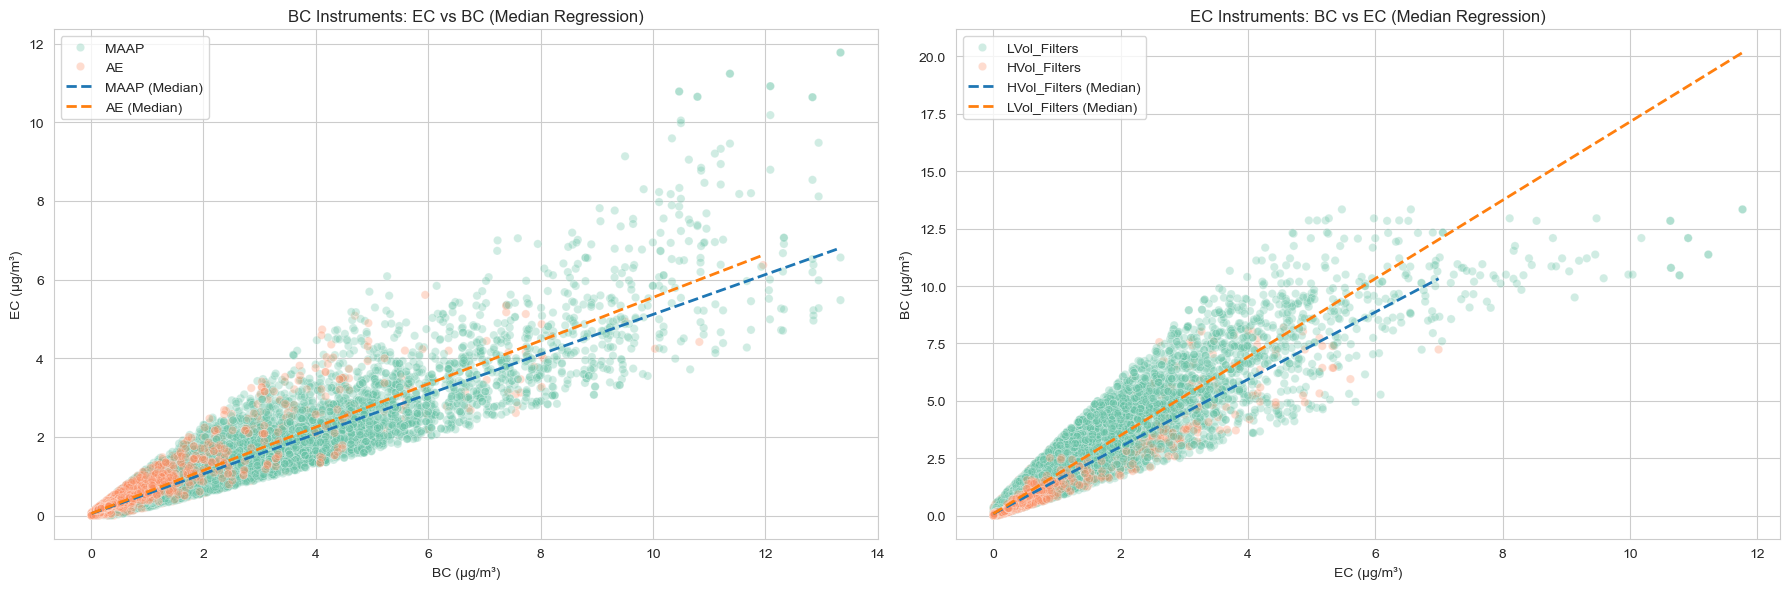

In [87]:
# Filter instruments (exclude UNKNOWN for EC)
instruments_bc = ["MAAP", "AE"]
instruments_ec = ["HVol_Filters", "LVol_Filters"]  # Removed UNKNOWN

df_bc = df_filtered[df_filtered["Instrument_BC"].isin(instruments_bc)]
df_ec = df_filtered[df_filtered["Instrument_EC"].isin(instruments_ec)]

# Initialize plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
palette = "Set2"

# BC Instruments plot
sns.scatterplot(x="BC", y="EC", data=df_bc, hue="Instrument_BC", 
                alpha=0.3, ax=ax1, palette=palette)

for instrument in instruments_bc:
    subset = df_bc[df_bc["Instrument_BC"] == instrument]
    model = smf.quantreg("EC ~ BC", subset).fit(q=0.5)
    x_pred = np.linspace(subset["BC"].min(), subset["BC"].max(), 100)
    ax1.plot(x_pred, model.predict(exog=dict(BC=x_pred)), 
             linestyle='--', linewidth=2, label=f"{instrument} (Median)")

ax1.set(title="BC Instruments: EC vs BC (Median Regression)",
       xlabel="BC (µg/m³)", ylabel="EC (µg/m³)")

# EC Instruments plot (without UNKNOWN)
sns.scatterplot(x="EC", y="BC", data=df_ec, hue="Instrument_EC", 
                alpha=0.3, ax=ax2, palette=palette)

for instrument in instruments_ec:
    subset = df_ec[df_ec["Instrument_EC"] == instrument]
    model = smf.quantreg("BC ~ EC", subset).fit(q=0.5)
    x_pred = np.linspace(subset["EC"].min(), subset["EC"].max(), 100)
    ax2.plot(x_pred, model.predict(exog=dict(EC=x_pred)), 
             linestyle='--', linewidth=2, label=f"{instrument} (Median)")

ax2.set(title="EC Instruments: BC vs EC (Median Regression)", 
       xlabel="EC (µg/m³)", ylabel="BC (µg/m³)")

# Final adjustments
for ax in [ax1, ax2]:
    ax.legend()
plt.tight_layout()
plt.show()

For the two BC instruments (MAAP and AE), we obtain nearly similar median slopes, suggesting comparable BC-EC relationships. For the EC instruments (UNKNOWN, Low Volume, and High Volume Filters), we obtain divergent median lines, indicating possible instrument-specific biases in the BC-EC ratios. However, these differences can perhaps be explained by the lack of data from the other two instruments compared to the LVol_Filter.

The regression plots reveal nuanced insights about instrument behavior. For BC instruments (MAAP and AE), the similar median slopes suggest comparable BC-EC relationships at typical concentration levels, despite earlier tests showing global distribution differences. This indicates that while these instruments might agree on central trends, they likely diverge in measuring extremes or handling variability. 

For EC instruments, the distinct slopes of HVol_Filters compared to LVol_Filters and UNKNOWN highlight systematic biases in how they associate BC with EC values. These findings emphasize that instruments cannot be considered fully interchangeable, while some show alignment in median relationships, their overall measurement characteristics (precision, outlier handling) require further validation to ensure robust air quality assessments.  

The analysis we're performing here is to examine the influence of the combinations of three factors (Instrument_BC, Instrument_EC, and Protocol) on the variable log_ratio. These three factors can each take multiple values, and each unique combination of these values may have a different impact on log_ratio.

In this first step, we are interested in understanding how the data is distributed across the possible combinations of these three factors. By creating a new variable that represents each of these combinations, we will be able to see how many data points exist for each combination and ensure that all possible combinations are present in the dataset. This will help us identify if there are any imbalances or missing combinations, which is important before moving to more advanced analyses.

In [105]:
# Create a deep copy of the filtered data
df_filtered_comb = df_filtered[df_filtered['Protocol'].isin(['NIOSH', 'EUSAAR']) & 
                               df_filtered['Instrument_BC'].isin(['MAAP', 'AE']) & 
                               df_filtered['Instrument_EC'].isin(['LVol_Filters', 'HVol_Filters'])].copy()

# Create a new variable for the eight possible combinations of the three factors
df_filtered_comb['combination'] = (df_filtered_comb['Instrument_BC'] + '_' + 
                                   df_filtered_comb['Instrument_EC'] + '_' + 
                                   df_filtered_comb['Protocol'])

# Reorder the 'combination' factor to set 'MAAP_LVol_Filters_NIOSH' as the reference
df_filtered_comb['combination'] = pd.Categorical(df_filtered_comb['combination'], 
                                                 categories=['MAAP_LVol_Filters_NIOSH', 
                                                             'MAAP_LVol_Filters_EUSAAR', 
                                                             'MAAP_HVol_Filters_EUSAAR', 
                                                             'AE_HVol_Filters_EUSAAR',
                                                             'AE_LVol_Filters_EUSAAR', 
                                                             'AE_LVol_Filters_NIOSH', 
                                                             'AE_HVol_Filters_NIOSH'])

# Display the unique combinations and their counts
comb_count = df_filtered_comb['combination'].value_counts()
print(comb_count)

combination
MAAP_LVol_Filters_NIOSH     6663
MAAP_LVol_Filters_EUSAAR    3251
MAAP_HVol_Filters_EUSAAR    2139
AE_HVol_Filters_EUSAAR      1913
AE_LVol_Filters_EUSAAR      1051
AE_LVol_Filters_NIOSH        208
AE_HVol_Filters_NIOSH          8
Name: count, dtype: int64


The ANOVA test (Analysis of Variance) will allow us to examine whether the means of log_ratio significantly differ between the different combinations of the three factors. This step is crucial to determine whether the observed differences in log_ratio can be explained by the specific combinations of the factors Instrument_BC, Instrument_EC, and Protocol. We will use a Type 2 ANOVA test to evaluate the impact of each combination on log_ratio and gain insight into the variability explained by each factor and their interaction.

In [112]:
from statsmodels.stats.anova import anova_lm

# Perform an ANOVA test to examine the impact of each combination on log_ratio
anova_table = anova_lm(model, typ=2)
print(anova_table)

                     sum_sq       df          F         PR(>F)
C(combination)   185.725206      6.0  250.37316  1.859185e-306
Residual        1882.424878  15226.0        NaN            NaN


The ANOVA test results show that the variable combination has a significant impact on log_ratio, with a very high F-statistic (250.4) and an extremely low p-value (1.86e-306). This indicates that there are significant differences between the different combinations of the three factors in terms of log_ratio. The ANOVA test confirms that the influence of the combinations on log_ratio is statistically significant, and the F-value suggests that these factors explain a large portion of the variability in log_ratio.

The ANOVA test we performed earlier confirmed that there are statistically significant differences in the average values of `log_ratio` across the different combinations of instruments and protocols. However, ANOVA only tells us that at least one group differs from the others, so it does not indicate which specific pairs of groups are significantly different from each other.

To answer this question, we need to perform a post-hoc analysis, which is a set of additional tests conducted after a significant ANOVA result. Among the available methods, the Tukey’s Honest Significant Difference (HSD) test is one of the most widely used. It allows us to compare all possible pairs of groups while controlling the family-wise error rate, that is, the probability of making at least one false positive when performing multiple comparisons.

Without such correction, testing each pair independently would inflate the risk of detecting significant differences just by chance. Tukey’s HSD adjusts for this by using a more conservative criterion for significance, ensuring that the overall error rate remains at the desired level (e.g., 5%). We use the function pairwise_tukeyhsd() from statsmodels.stats.multicomp to apply this test to our data. This function compares the means of log_ratio between all combinations of the combination factor column and determines which differences are statistically significant.

In [128]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Exclude the combination with too few data points
excluded_combination = 'AE_HVol_Filters_NIOSH'
df_tukey = df_filtered_comb[df_filtered_comb['combination'] != excluded_combination].copy()

# Apply Tukey HSD test
tukey_result = pairwise_tukeyhsd(endog=df_tukey['log_ratio'],
                                 groups=df_tukey['combination'],
                                 alpha=0.05)

# Display the result summary
print(tukey_result.summary())

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1                   group2          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------
  AE_HVol_Filters_EUSAAR   AE_LVol_Filters_EUSAAR   0.0897    0.0  0.0512  0.1281   True
  AE_HVol_Filters_EUSAAR    AE_LVol_Filters_NIOSH   0.1007 0.0012  0.0276  0.1739   True
  AE_HVol_Filters_EUSAAR MAAP_HVol_Filters_EUSAAR  -0.0545    0.0  -0.086  -0.023   True
  AE_HVol_Filters_EUSAAR MAAP_LVol_Filters_EUSAAR  -0.0994    0.0 -0.1283 -0.0705   True
  AE_HVol_Filters_EUSAAR  MAAP_LVol_Filters_NIOSH   -0.237    0.0  -0.263  -0.211   True
  AE_LVol_Filters_EUSAAR    AE_LVol_Filters_NIOSH   0.0111 0.9984  -0.065  0.0871  False
  AE_LVol_Filters_EUSAAR MAAP_HVol_Filters_EUSAAR  -0.1441    0.0 -0.1819 -0.1064   True
  AE_LVol_Filters_EUSAAR MAAP_LVol_Filters_EUSAAR   -0.189    0.0 -0.2246 -0.1535   True
  AE_LVol_Filters_EUS

The table above presents the results of pairwise comparisons between all combinations (excluding AE_HVol_Filters_NIOSH due to its small sample size). Each row compares two combinations of Instrument_BC, Instrument_EC, and Protocol, and shows:
- group1 and group2: the two combinations being compared,
- meandiff: the difference in mean log_ratio between the two groups,
- p-adj: the adjusted p-value accounting for multiple comparisons,
- lower and upper: the confidence interval for the mean difference,
- reject: whether the null hypothesis (equal means) is rejected at the 5% level.

Interpretation guidelines:
- If reject is True, then the difference between the two groups is statistically significant at the 0.05 level.
- A positive meandiff means the first group tends to have higher log_ratio than the second.
- The confidence interval helps quantify the uncertainty around the difference.
- The plot shows which combinations differ significantly: non-overlapping CIs indicate significant differences.

This analysis gives a more detailed view of which specific combinations of Instrument_BC, Instrument_EC, and Protocol differ in terms of their EC/BC log-ratio. Most pairwise comparisons are statistically significant, since reject is often True, indicating systematic differences in log_ratio between the combinations. Some of the largest differences occur between MAAP_LVol_Filters_NIOSH and other combinations:
- AE_LVol_Filters_NIOSH and MAAP_LVol_Filters_NIOSH (mean diff ≈ -0.3378),
- AE_LVol_Filters_EUSAAR and MAAP_LVol_Filters_NIOSH (mean diff ≈ -0.3267),
- AE_HVol_Filters_EUSAAR and MAAP_LVol_Filters_NIOSH (mean diff ≈ -0.237),

This suggests that the MAAP_LVol_Filters_NIOSH configuration yields to higher EC/BC log-ratios compared to AE-based combinations. The only comparison not statistically significant is between:
- AE_LVol_Filters_EUSAAR and AE_LVol_Filters_NIOSH (p-adj = 0.9984), indicating that the protocol (EUSAAR vs NIOSH) has little effect when the same AE and LVol configuration is used.

Conclusion, the post-hoc Tukey HSD (Honest Significant Difference) test reveals that the combinations of instruments and protocols have a statistically significant effect on the log_ratio for most pairwise comparisons. This confirms that differences in instrumentation and methodology can meaningfully alter the measured EC/BC relationship. Therefore, any further modeling or harmonization effort should carefully account for the specific combination used during data collection.

We now perform a linear regression to quantify the specific effect of each combination on log_ratio. Regression will allow us to compute the coefficients of each combination and understand how much each factor or combination influences log_ratio. Additionally, regression will provide us with p-values associated with each combination to test their statistical significance. When you apply OLS regression to categorical variables like this, each level of the categorical variable combination is compared to the reference category (which you specified in the previous message as MAAP_LVol_Filters_NIOSH). For each level of the combination factor, the model estimates a coefficient that represents the difference in the mean of log_ratio relative to the reference category. 

The equation of the model can be written as :
- log_ratio = β0 + β1⋅C(combination)[T.MAAP_LVol_Filters_EUSAAR] + ⋯ + β7⋅C(combination)[T.AE_HVol_Filters_NIOSH]

Where :
- β0 is the intercept (the mean of log_ratio for the reference category, MAAP_LVol_Filters_NIOSH).
- β1, …, β7 are the coefficients for the other combinations, indicating how much the mean of log_ratio changes relative to the reference category.
- Each coefficient represents the difference in the mean value of log_ratio for each combination compared to MAAP_LVol_Filters_NIOSH.

If the regression output provides, for MAAP_LVol_Filters_NIOSH, the coefficients -0.4390. Then, in the equation for log_ratio, the β coefficient corresponding would be -0.4390. And, each coefficient represents the difference in the mean log_ratio between the combination in question and the reference category (MAAP_LVol_Filters_NIOSH), while positive coefficients indicate that the combination leads to an increase in log_ratio compared to the reference category, but negative coefficients indicate a decrease.

Each indicator is a dummy variable that takes the value of 1 if the observation belongs to the corresponding category, and 0 otherwise. This equation shows how log_ratio is modeled based on the different combinations of Instrument_BC, Instrument_EC, and Protocol, with each combination's effect on the dependent variable represented by a corresponding coefficient.

In [131]:
from statsmodels.formula.api import ols

# Create a regression model with the combined variable
model = ols('log_ratio ~ C(combination)', data=df_filtered_comb).fit()

# Model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_ratio   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     250.4
Date:                Sat, 17 May 2025   Prob (F-statistic):          1.86e-306
Time:                        17:02:14   Log-Likelihood:                -5689.3
No. Observations:               15233   AIC:                         1.139e+04
Df Residuals:                   15226   BIC:                         1.145e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

The regression model summary provides the coefficients for each combination, as well as the p-values associated with these coefficients. Here's an interpretation : 
- The coefficients represent the impact of each combination relative to the reference category (likely the combination with 0 for each factor). For example, if the coefficient for AE_LVol_Filters_EUSAAR is 0.3265, it means that this combination increases log_ratio by 0.3265 compared to the reference combination (MAAP_LVol_Filters_NIOSH).
- The p-values indicate whether the effect of a combination is statistically significant. If a p-value is less than 0.05, it means that this combination has a significant effect on log_ratio. For example, the p-values for some combinations are < 0.05, indicating that these combinations significantly affect log_ratio.

The results show that different combinations of the three factors (Instrument_BC, Instrument_EC, and Protocol) have statistically significant effects on log_ratio. Also, the p-values for most of the combinations are very low (e.g., less than 0.05), indicating that the differences in log_ratio between the combinations are not due to random chance, but are significant. However, the R-squared value from the OLS regression model is relatively low (around 0.090), indicating that only a small portion of the variance in log_ratio is explained by the combinations of the three factors. This suggests that other factors, not included in the model, may contribute to the variability in log_ratio. Despite this, the significant p-values for many of the coefficients suggest that the factors included in the model still have a meaningful impact on log_ratio, even if they do not explain all the variability. 

View the EC/BC rapports to combine instruments and protocols :
- MAAP_LVol_Filters_NIOSH : EC ≈ 0.509 ⋅ BC
- MAAP_LVol_Filters_EUSAAR : EC ≈ 0.584 ⋅ BC
- MAAP_HVol_Filters_EUSAAR : EC ≈ 0.611 ⋅ BC
- AE_HVol_Filters_EUSAAR : EC ≈ 0.645 ⋅ BC
- AE_LVol_Filters_EUSAAR : EC ≈ 0.706 ⋅ BC
- AE_LVol_Filters_NIOSH : EC ≈ 0.713 ⋅ BC
- AE_HVol_Filters_NIOSH: EC ≈ 0.712 ⋅ BC

After conducting the OLS regression to examine the relationship between EC and BC for different combinations of Instrument_BC, Instrument_EC, and Protocol, it is crucial to explore the structure of this relationship in a more robust way. While OLS provides a mean estimate of the relationship, Quantile Regression focuses on specific quantiles of the distribution of the data, particularly the median (q = 0.5) in this case.

This analysis will allow us to better understand how the central tendency of the EC ~ BC relationship behaves across different combinations. Since Quantile Regression is less sensitive to outliers and heteroscedasticity, it will give us a clearer picture of the relationship's structure, particularly in cases where the OLS regression might be influenced by extreme values.

By applying Quantile Regression to the median, we can see how the central part of the distribution of BC changes with respect to EC, and compare these results across the different combinations of factors (Instrument_BC, Instrument_EC, and Protocol). This will help validate our previous findings from the OLS regression and give us more confidence in the relationships we observe.

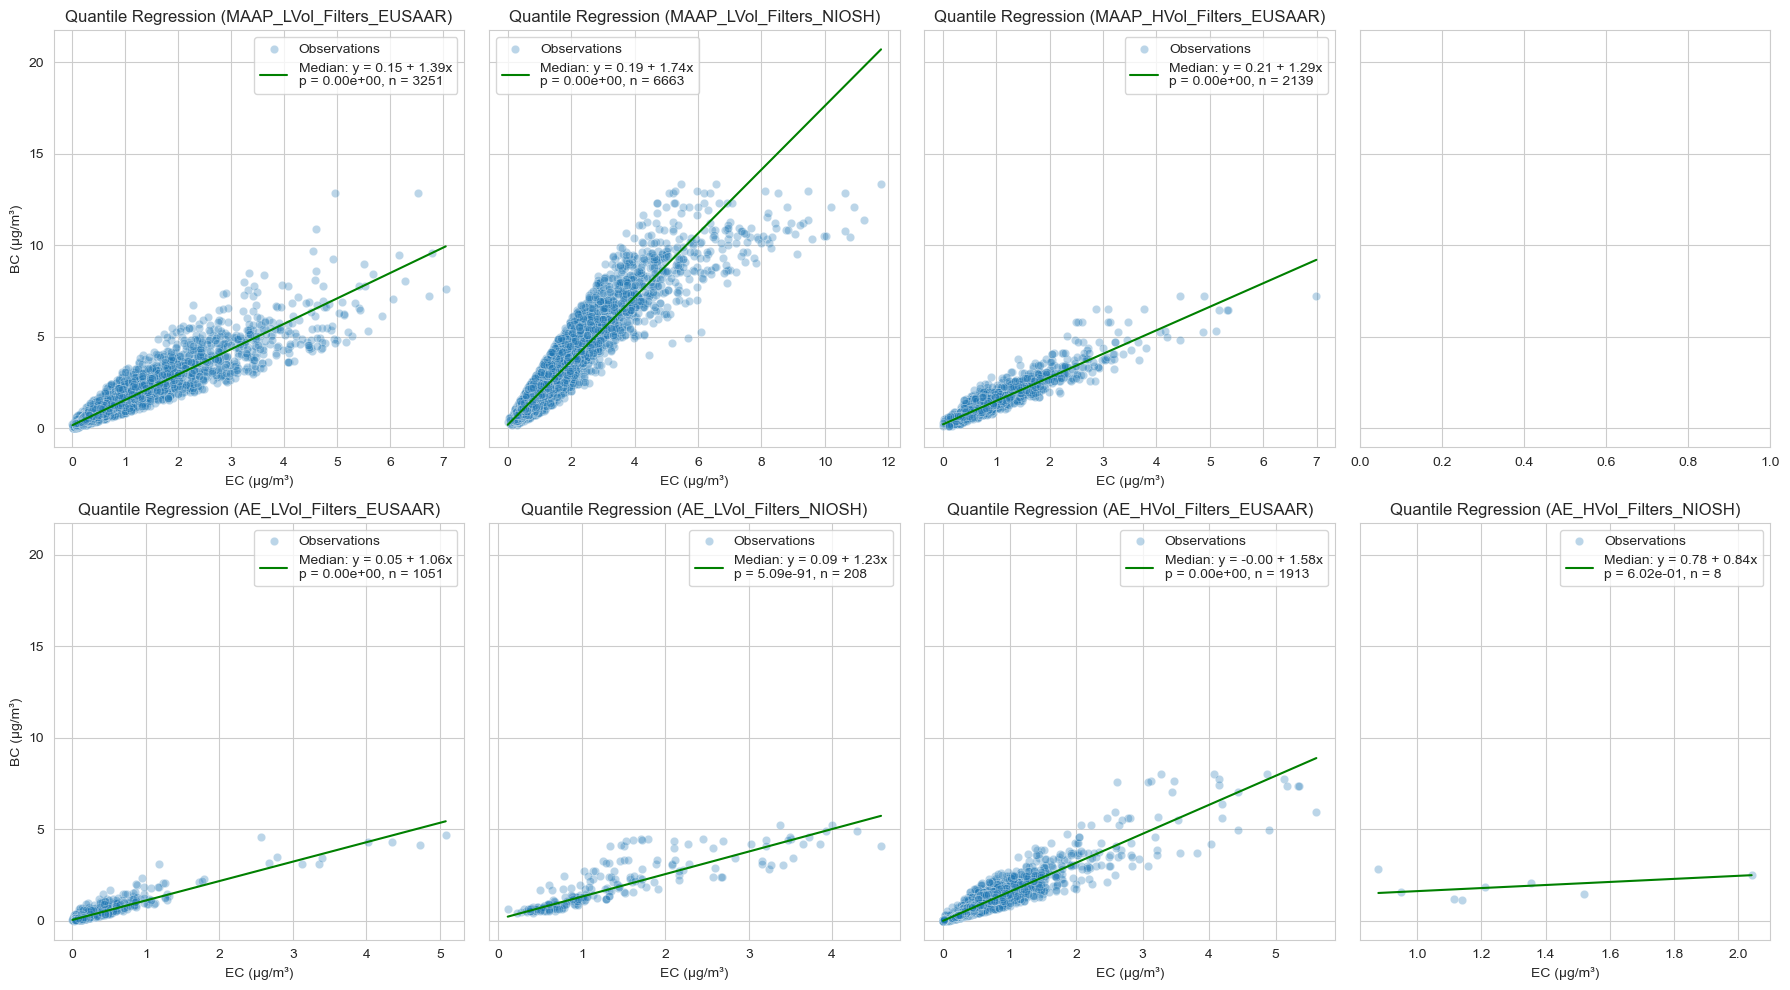

In [134]:
# Set up combination labels
combination_labels = {
    "MAAP_LVol_Filters_EUSAAR": "MAAP_LVol_Filters_EUSAAR", 
    "MAAP_LVol_Filters_NIOSH": "MAAP_LVol_Filters_NIOSH",
    "MAAP_HVol_Filters_EUSAAR": "MAAP_HVol_Filters_EUSAAR",
    "MAAP_HVol_Filters_NIOSH": "MAAP_HVol_Filters_NIOSH",
    "AE_LVol_Filters_EUSAAR": "AE_LVol_Filters_EUSAAR", 
    "AE_LVol_Filters_NIOSH": "AE_LVol_Filters_NIOSH",
    "AE_HVol_Filters_EUSAAR": "AE_HVol_Filters_EUSAAR", 
    "AE_HVol_Filters_NIOSH": "AE_HVol_Filters_NIOSH"
}

# Create figure with 2 rows (Quantile Regression) and 4 columns (one per combination)
fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharey=True)

# Loop over each combination
for i, comb in enumerate(combination_labels.keys()):
    # Filter data for current combination
    df_comb = df_filtered_comb[df_filtered_comb["combination"] == comb].dropna(subset=["EC", "BC"])
    
    if df_comb.empty:
        continue

    # Quantile Regression (Median)
    qr_model = smf.quantreg("BC ~ EC", df_comb).fit(q=0.5)
    intercept_qr, slope_qr = qr_model.params
    pval_qr = qr_model.pvalues["EC"]
    n_obs = len(df_comb)

    # Plot Quantile results
    ax = axes[i // 4, i % 4]
    sns.scatterplot(x="EC", y="BC", data=df_comb, ax=ax, alpha=0.3, label="Observations")
    x_vals = np.linspace(df_comb["EC"].min(), df_comb["EC"].max(), 100)
    ax.plot(x_vals, intercept_qr + slope_qr * x_vals, color="green", 
            label=f"Median: y = {intercept_qr:.2f} + {slope_qr:.2f}x\np = {pval_qr:.2e}, n = {n_obs}")
    ax.set_title(f"Quantile Regression ({combination_labels[comb]})")
    ax.set_xlabel("EC (µg/m³)")
    if i % 4 == 0:
        ax.set_ylabel("BC (µg/m³)")
    ax.legend()

plt.tight_layout()
plt.show()

Let's create a single graph with all median regression lines (one per combination) superimposed on a single chart to visually compare the impact of different combinations (MAAP/AE, LVol/HVol, EUSAAR/NIOSH).

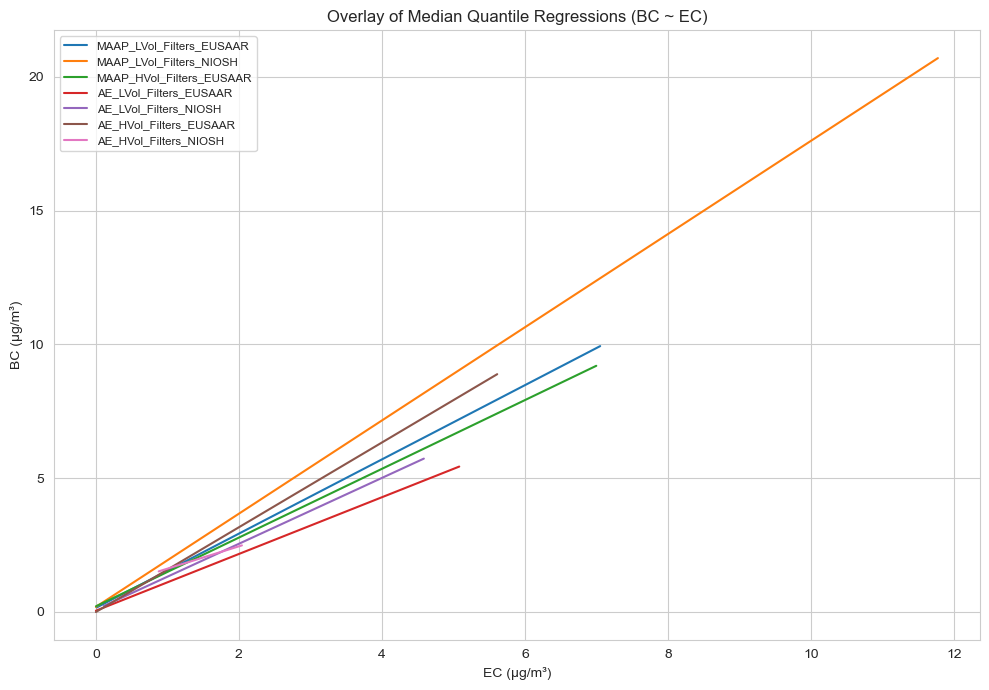

In [137]:
# Create a single figure to overlay all median quantile regression lines
plt.figure(figsize=(10, 7))

# Loop through each combination
for comb in combination_labels.keys():
    # Filter data for the current combination
    df_comb = df_filtered_comb[df_filtered_comb["combination"] == comb].dropna(subset=["EC", "BC"])
    
    if df_comb.empty:
        continue

    # Fit median (0.5) quantile regression
    qr_model = smf.quantreg("BC ~ EC", df_comb).fit(q=0.5)
    intercept_qr, slope_qr = qr_model.params
    
    # Generate values for the regression line
    x_vals = np.linspace(df_comb["EC"].min(), df_comb["EC"].max(), 100)
    y_vals = intercept_qr + slope_qr * x_vals
    
    # Plot the regression line
    plt.plot(x_vals, y_vals, label=comb)

# Format the plot
plt.title("Overlay of Median Quantile Regressions (BC ~ EC)")
plt.xlabel("EC (µg/m³)")
plt.ylabel("BC (µg/m³)")
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

The Quantile Regression results at the median (q = 0.5) provide valuable insights into the central tendency of the EC ~ BC relationship for each combination of Instrument_BC, Instrument_EC, and Protocol. Key findings :
- The green lines represent the median regression for each combination, and the scatter points represent the data points.
- For most combinations, the median regression line shows a positive relationship between EC and BC, indicating that as EC increases, BC also tends to increase.
- The p-values shown in the legend for each combination give an indication of the statistical significance of the median regression for each combination. A p-value less than 0.05 indicates that the relationship is statistically significant.

Overall, the plots provide a comprehensive view of how different combinations of factors influence the central tendency of the EC ~ BC relationship, confirming that the interaction between these factors plays an important role in shaping the relationship.